In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn.decomposition import PCA,FastICA
from sklearn.datasets import fetch_mldata
%matplotlib inline
from sklearn.utils import shuffle
# from tga import TGA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from rpca import R_pca
from datetime import datetime
import cv2


mnist = fetch_mldata("MNIST original")
x_dat, y_dat = mnist.data[:] / 255., mnist.target[:]
x_dat, y_dat = shuffle(x_dat, y_dat)


In [2]:
def showDigitImage(array):
    t = (array).reshape(28,28)
    plt.imshow(t)
    plt.show()
    
def filt_num(xs,ys,ns):
    xs = xs.copy()
    ys = ys.copy()
    all_truth = [False]*len(ys)
    for i in ns:
        cur_truth = ys==i
        all_truth = [a or b for a,b in zip(all_truth,cur_truth)]
    return xs[all_truth],ys[all_truth]

new_xs,new_ys = filt_num(x_dat,y_dat,[6,9])
# new_xs[0]

In [3]:
from sklearn.preprocessing import StandardScaler
std_xs = StandardScaler().fit_transform(new_xs)
# std_xs[0]

In [130]:
def sp_noise(image,prob=0.2):

    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(len(image)):
        rdn = np.random.random()
        if rdn < prob:
            output[i] = 0
        elif rdn > thres:
            output[i] = 1
        else:
            output[i] = image[i]
    return output

def rotate180(features):
    return features.copy()[::-1]
  
def gaussian(pure):
    pure = pure.copy()
    noise = np.random.normal(0, 0.3, pure.shape)
    signal = pure + noise
    return signal
    
def vertical_flip(features):
    return np.flip(features.copy().reshape(28,28),1).ravel()

def add_noise_to_train_set(x_train,p,noise_f):
    rs = []
    thresholds = np.random.rand(len(x_train)) < p
    for i in range(len(x_train)):
        if(thresholds[i]):
#             print(i)
            rs += [noise_f(x_train[i].copy())]
        else:
            rs += [x_train[i].copy()]
    return rs

def scale_down(xs,new_shape=(8,8)):
    xs = xs.copy()
    t = xs.reshape(28,28)
    res = cv2.resize(t, dsize=new_shape)
    rs = np.zeros((28,28))
    for i in range(new_shape[1]):
        for j in range(new_shape[0]):
            
            rs[i+10][j+10] = res[i][j]
    rs = rs.reshape(784,)
    return rs

In [393]:

def iterative_run_original(xs,ys,n,f=False,p=0.1):
    rs = []
    time_rs = []
#     tga_rs = []
    for i in range(n):
        print(i,end=',')

        X_train, X_test, y_train, y_test = train_test_split(xs,ys, test_size=0.3)
        if(f!=False):
            X_train = add_noise_to_train_set(X_train,p,f)
            X_test = add_noise_to_train_set(X_test,p,f)
        
        X_train = StandardScaler().fit_transform(X_train)
        X_test = StandardScaler().fit_transform(X_test)
        
        startTime = datetime.now()

        logisticRegr = LogisticRegression(solver = 'lbfgs')
        logisticRegr.fit(X_train, y_train)
        right = np.sum(logisticRegr.predict(X_test)==y_test)
        
        endTime = datetime.now()

        
        rs.append(right/len(y_test))
        time_rs.append(endTime-startTime)
        
    return rs,time_rs
        

In [375]:

def iterative_run_pca(xs,ys,c,n,f=False,p=0.1):
    pca_rs = []
    time_rs = []
    for i in range(n):
        print(i,end=',')
        X_train, X_test, y_train, y_test = train_test_split(xs,ys, test_size=0.3)

        if(f!=False):
            X_train = add_noise_to_train_set(X_train,p,f)
            X_test = add_noise_to_train_set(X_test,p,f)
        
        X_train = StandardScaler().fit_transform(X_train)
        X_test = StandardScaler().fit_transform(X_test)
        
        pca = PCA(n_components=c)
        
        startTime = datetime.now()

        pca.fit(X_train)
        pca_dat = pca.transform(X_train)  
        
        logisticRegr = LogisticRegression(solver = 'lbfgs')
        logisticRegr.fit(pca_dat, y_train)
        right = np.sum(logisticRegr.predict(pca.transform(X_test))==y_test)
        
        endTime = datetime.now()
        
        pca_rs.append(right/len(y_test))
        time_rs.append(endTime-startTime)
        
    return pca_rs,time_rs
        

In [376]:
# iterative_run_pca([],[],0,1,rotate180)

In [377]:

def iterative_run_ica(xs,ys,c,n,f=False,p=0.1):
    time_rs = []
    ica_rs = []
    for i in range(n):
        print(i,end=',')

        X_train, X_test, y_train, y_test = train_test_split(xs,ys, test_size=0.3)
        
        if(f!=False):
            X_train = add_noise_to_train_set(X_train,p,f)
            X_test = add_noise_to_train_set(X_test,p,f)
        
        X_train = StandardScaler().fit_transform(X_train)
        X_test = StandardScaler().fit_transform(X_test)
        
        ica = FastICA(n_components=c)
        startTime = datetime.now()

        ica.fit(X_train)
        ica_dat = ica.transform(X_train)
        
        logisticRegr = LogisticRegression(solver = 'lbfgs')
        logisticRegr.fit(ica_dat, y_train)
        right = np.sum(logisticRegr.predict(ica.transform(X_test))==y_test)
        
        endTime = datetime.now()

        ica_rs.append(right/len(y_test))
        time_rs.append(endTime-startTime)

    return ica_rs,time_rs
        

In [378]:
def iterative_run_rpca(xs,ys,c,n,f=False,p=0.1):
    rpca_rs = []
    time_rs = []
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(xs,ys, test_size=0.3)
        print(i,end=',')
        
        if(f!=False):
            X_train = add_noise_to_train_set(X_train,p,f)
            X_test = add_noise_to_train_set(X_test,p,f)
        
        X_train = StandardScaler().fit_transform(X_train)
        X_test = StandardScaler().fit_transform(X_test)
        

        startTime = datetime.now()

        L, S = R_pca(X_train).fit(max_iter=100,iter_print=20)
                
        filtered = np.isfinite(L).all(axis=1)
        L = L[filtered]
        y_train = y_train[filtered]
        
        if(len(L)<0.7*len(X_train)):
            print('L not enough:',len(L))
            continue
        pca = PCA(n_components=c)
        pca.fit(L)
        pca_dat = pca.transform(X_train) 

        
        logisticRegr = LogisticRegression(solver = 'lbfgs')
        logisticRegr.fit(pca_dat, y_train)
        
        right = np.sum(logisticRegr.predict(pca.transform(X_test))==y_test)
        
        endTime = datetime.now()

        rpca_rs.append(right/len(y_test))
        time_rs.append(endTime-startTime)

        
    return rpca_rs,time_rs

In [9]:
# import rpca; from rpca import R_pca;
# import importlib
# importlib.reload(rpca)


In [380]:
original_rs,original_rs_time = iterative_run_original(new_xs,new_ys,20)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

In [381]:
pca5_rs,pca5_rs_time = iterative_run_pca(new_xs,new_ys,5,20)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

In [382]:
ica5_rs,ica5_rs_time = iterative_run_ica(new_xs,new_ys,5,20)

0,1,

/usr/local/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

In [383]:
rpca5_rs,rpca5_rs_time = iterative_run_rpca(new_xs,new_ys,5,20)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

In [384]:
pca10_rs,pca10_time = iterative_run_pca(new_xs,new_ys,10,20)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

In [385]:
ica10_rs,ica10_rs_time = iterative_run_ica(new_xs,new_ys,10,20)

0,

/usr/local/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

In [386]:
rpca10_rs,rpca10_rs_time = iterative_run_rpca(new_xs,new_ys,10,20)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

In [387]:
pca15_rs,pca15_rs_time = iterative_run_pca(new_xs,new_ys,15,20)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

In [388]:
ica15_rs,ica15_rs_time = iterative_run_ica(new_xs,new_ys,15,20)

0,

/usr/local/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

/usr/local/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:312: RuntimeWarning: divide by zero encountered in true_divide
  K = (u / d).T[:n_components]  # see (6.33) p.140
/usr/local/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:312: RuntimeWarning: invalid value encountered in true_divide
  K = (u / d).T[:n_components]  # see (6.33) p.140


In [389]:
rpca15_rs,rpca15_rs_time = iterative_run_rpca(new_xs,new_ys,15,20)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

In [390]:
original_rs_time[0].total_seconds(),pca5_rs_time[0].total_seconds(),ica5_rs_time[0].total_seconds(),rpca5_rs_time[0].total_seconds()

(1.160103, 0.617052, 3.363733, 8.160698)

# ---------------------------------------

In [379]:
len(new_xs)

13834

In [43]:
# gaussed_xs = add_noise_to_train_set(new_xs,0.2,gaussian)
# std_gaussed_xs = StandardScaler().fit_transform(gaussed_xs)

In [394]:
gaussed_original_rs,gaussed_original_rs_time = iterative_run_original(new_xs,new_ys,20,gaussian)


0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

In [395]:
gaussed_pca5_rs,gaussed_pca5_rs_time = iterative_run_pca(new_xs,new_ys,5,20,gaussian)
gaussed_pca10_rs,gaussed_pca10_rs_time = iterative_run_pca(new_xs,new_ys,10,20,gaussian)
gaussed_pca15_rs,gaussed_pca15_rs_time = iterative_run_pca(new_xs,new_ys,15,20,gaussian)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

In [396]:
gaussed_ica5_rs,gaussed_ica5_rs_time = iterative_run_ica(new_xs,new_ys,5,20,gaussian)
gaussed_ica10_rs,gaussed_ica10_rs_time = iterative_run_ica(new_xs,new_ys,10,20,gaussian)
gaussed_ica15_rs,gaussed_ica15_rs_time = iterative_run_ica(new_xs,new_ys,15,20,gaussian)

0,

/usr/local/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

In [397]:
gaussed_rpca5_rs,gaussed_rpca5_rs_time = iterative_run_rpca(new_xs,new_ys,5,20,gaussian)
gaussed_rpca10_rs,gaussed_rpca10_rs_time = iterative_run_rpca(new_xs,new_ys,10,20,gaussian)
gaussed_rpca15_rs,gaussed_rpca15_rs_time = iterative_run_rpca(new_xs,new_ys,15,20,gaussian)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

In [49]:
# salted_xs = add_noise_to_train_set(new_xs,0.2,sp_noise)
# std_salted_xs = StandardScaler().fit_transform(salted_xs)


In [398]:
salted_original_rs,salted_original_rs_time = iterative_run_original(new_xs,new_ys,20,sp_noise)


0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

In [399]:
salted_pca5_rs,salted_pca5_rs_time = iterative_run_pca(new_xs,new_ys,5,20,sp_noise)
salted_pca10_rs,salted_pca5_rs_time = iterative_run_pca(new_xs,new_ys,10,20,sp_noise)
salted_pca15_rs,salted_pca5_rs_time = iterative_run_pca(new_xs,new_ys,15,20,sp_noise)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

In [400]:
salted_ica5_rs,salted_ica5_rs_time = iterative_run_ica(new_xs,new_ys,5,20,sp_noise)
salted_ica10_rs,salted_ica10_rs_time = iterative_run_ica(new_xs,new_ys,10,20,sp_noise)
salted_ica15_rs,salted_ica15_rs_time = iterative_run_ica(new_xs,new_ys,15,20,sp_noise)

0,

/usr/local/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

In [401]:
salted_rpca5_rs,salted_rpca5_rs_time = iterative_run_rpca(new_xs,new_ys,5,20,sp_noise)
salted_rpca10_rs,salted_rpca10_rs_time = iterative_run_rpca(new_xs,new_ys,10,20,sp_noise)
salted_rpca15_rs,salted_rpca15_rs_time = iterative_run_rpca(new_xs,new_ys,15,20,sp_noise)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

In [55]:
# vert_flip_xs = add_noise_to_train_set(new_xs,0.2,vertical_flip)
# std_vert_flip_xs = StandardScaler().fit_transform(vert_flip_xs)


In [402]:
vert_flip_original_rs,vert_flip_original_rs_time = iterative_run_original(new_xs,new_ys,20,vertical_flip)


0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

In [403]:
vert_flip_pca5_rs,vert_flip_pca5_rs_time = iterative_run_pca(new_xs,new_ys,5,20,vertical_flip)
vert_flip_pca10_rs,vert_flip_pca10_rs_time = iterative_run_pca(new_xs,new_ys,10,20,vertical_flip)
vert_flip_pca15_rs,vert_flip_pca15_rs_time = iterative_run_pca(new_xs,new_ys,15,20,vertical_flip)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

In [404]:
vert_flip_ica5_rs,vert_flip_ica5_rs_time = iterative_run_ica(new_xs,new_ys,5,20,vertical_flip)
vert_flip_ica10_rs,vert_flip_ica10_rs_time = iterative_run_ica(new_xs,new_ys,10,20,vertical_flip)
vert_flip_ica15_rs,vert_flip_ica15_rs_time = iterative_run_ica(new_xs,new_ys,15,20,vertical_flip)

0,

/usr/local/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

In [405]:
vert_flip_rpca5_rs,vert_flip_rpca5_rs_time = iterative_run_rpca(new_xs,new_ys,5,20,vertical_flip)
vert_flip_rpca10_rs,vert_flip_rpca10_rs_time = iterative_run_rpca(new_xs,new_ys,10,20,vertical_flip)
vert_flip_rpca15_rs,vert_flip_rpca15_rs_time = iterative_run_rpca(new_xs,new_ys,15,20,vertical_flip)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

In [406]:
# rotate_xs = add_noise_to_train_set(new_xs,0.2,rotate180)
# std_rotate_xs = StandardScaler().fit_transform(rotate_xs)


In [407]:
rotate_original_rs,rotate_original_rs_time = iterative_run_original(new_xs,new_ys,20,rotate180)


0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

In [408]:
rotate_pca5_rs,rotate_pca5_rs_time = iterative_run_pca(new_xs,new_ys,5,20,rotate180)
rotate_pca10_rs,rotate_pca10_rs_time = iterative_run_pca(new_xs,new_ys,10,20,rotate180)
rotate_pca15_rs,rotate_pca15_rs_time = iterative_run_pca(new_xs,new_ys,15,20,rotate180)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

In [409]:
rotate_ica5_rs,rotate_ica5_rs_time = iterative_run_ica(new_xs,new_ys,5,20,rotate180)
rotate_ica10_rs,rotate_ica10_rs_time = iterative_run_ica(new_xs,new_ys,10,20,rotate180)
rotate_ica15_rs,rotate_ica15_rs_time = iterative_run_ica(new_xs,new_ys,15,20,rotate180)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,

/usr/local/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

In [410]:
rotate_rpca5_rs,rotate_rpca5_rs_time = iterative_run_rpca(new_xs,new_ys,5,20,rotate180)
rotate_rpca10_rs,rotate_rpca10_rs_time = iterative_run_rpca(new_xs,new_ys,10,20,rotate180)
rotate_rpca15_rs,rotate_rpca15_rs_time = iterative_run_rpca(new_xs,new_ys,15,20,rotate180)

0,L not enough: 0
1,2,L not enough: 0
3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,L not enough: 0
16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

In [411]:
# scaled_xs = add_noise_to_train_set(new_xs,0.2,scale_down)
# std_scaled_xs = StandardScaler().fit_transform(scaled_xs)


In [412]:
scaled_original_rs,scaled_original_rs_time = iterative_run_original(new_xs,new_ys,20,scale_down)


0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

In [413]:
scaled_pca5_rs,scaled_pca5_rs_time = iterative_run_pca(new_xs,new_ys,5,20,scale_down)
scaled_pca10_rs,scaled_pca10_rs_time = iterative_run_pca(new_xs,new_ys,10,20,scale_down)
scaled_pca15_rs,scaled_pca15_rs_time = iterative_run_pca(new_xs,new_ys,15,20,scale_down)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

In [414]:
scaled_ica5_rs,scaled_ica5_rs_time = iterative_run_ica(new_xs,new_ys,5,20,scale_down)
scaled_ica10_rs,scaled_ica10_rs_time = iterative_run_ica(new_xs,new_ys,10,20,scale_down)
scaled_ica15_rs,scaled_ica15_rs_time = iterative_run_ica(new_xs,new_ys,15,20,scale_down)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,

/usr/local/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

In [415]:
scaled_rpca5_rs,scaled_rpca5_rs_time = iterative_run_rpca(new_xs,new_ys,5,20,scale_down)
scaled_rpca10_rs,scaled_rpca10_rs_time = iterative_run_rpca(new_xs,new_ys,10,20,scale_down)
scaled_rpca15_rs,scaled_rpca15_rs_time = iterative_run_rpca(new_xs,new_ys,15,20,scale_down)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

In [507]:
def cal_error(xss,tol=0.5):
    rs = []
#     print(xss)
    for each_c in xss:
        keep = []
        for each in each_c:
            if each < tol:
                keep += [each]
            else:
                print(each)
#         print(keep)
        rs += [np.array(keep)]
    return rs

In [448]:


clean_score_pca = [1-np.array(pca5_rs),1-np.array(pca10_rs),1-np.array(pca15_rs)]
salted_score_pca = [1-np.array(salted_pca5_rs),1-np.array(salted_pca10_rs),1-np.array(salted_pca15_rs)]
vert_score_pca = [1-np.array(vert_flip_pca5_rs),1-np.array(vert_flip_pca10_rs),1-np.array(vert_flip_pca15_rs)]
rotate_score_pca = [1-np.array(rotate_pca5_rs),1-np.array(rotate_pca10_rs),1-np.array(rotate_pca15_rs)]
scaled_score_pca = [1-np.array(scaled_pca5_rs),1-np.array(scaled_pca10_rs),1-np.array(scaled_pca15_rs)]
gaussed_score_pca = [1-np.array(gaussed_pca5_rs),1-np.array(gaussed_pca10_rs),1-np.array(gaussed_pca15_rs)]


clean_score_ica = [1-np.array(ica5_rs),1-np.array(ica10_rs),1-np.array(ica15_rs)]
salted_score_ica = [1-np.array(salted_ica5_rs),1-np.array(salted_ica10_rs),1-np.array(salted_ica15_rs)]
vert_score_ica = [1-np.array(vert_flip_ica5_rs),1-np.array(vert_flip_ica10_rs),1-np.array(vert_flip_ica15_rs)]
rotate_score_ica = [1-np.array(rotate_ica5_rs),1-np.array(rotate_ica10_rs),1-np.array(rotate_ica15_rs)]
scaled_score_ica = [1-np.array(scaled_ica5_rs),1-np.array(scaled_ica10_rs),1-np.array(scaled_ica15_rs)]
gaussed_score_ica = [1-np.array(gaussed_ica5_rs),1-np.array(gaussed_ica10_rs),1-np.array(gaussed_ica15_rs)]


clean_score_rpca = [1-np.array(rpca5_rs),1-np.array(rpca10_rs),1-np.array(rpca15_rs)]
salted_score_rpca = [1-np.array(salted_rpca5_rs),1-np.array(salted_rpca10_rs),1-np.array(salted_rpca15_rs)]
vert_score_rpca = [1-np.array(vert_flip_rpca5_rs),1-np.array(vert_flip_rpca10_rs),1-np.array(vert_flip_rpca15_rs)]
rotate_score_rpca = [1-np.array(rotate_rpca5_rs),1-np.array(rotate_rpca10_rs),1-np.array(rotate_rpca15_rs)]
scaled_score_rpca = [1-np.array(scaled_rpca5_rs),1-np.array(scaled_rpca10_rs),1-np.array(scaled_rpca15_rs)]
gaussed_score_rpca = [1-np.array(gaussed_rpca5_rs),1-np.array(gaussed_rpca10_rs),1-np.array(gaussed_rpca15_rs)]


import pickle

saved = {'clean_score_pca': clean_score_pca,'salted_score_pca':salted_score_pca,'vert_score_pca':vert_score_pca,
         'rotate_score_pca':rotate_score_pca,'scaled_score_pca':scaled_score_pca,'gaussed_score_pca':gaussed_score_pca,
        'clean_score_ica': clean_score_ica,'salted_score_ica':salted_score_ica,'vert_score_ica':vert_score_ica,
         'rotate_score_ica':rotate_score_ica,'scaled_score_ica':scaled_score_ica,'gaussed_score_ica':gaussed_score_ica,
        'clean_score_rpca': clean_score_rpca,'salted_score_rpca':salted_score_rpca,'vert_score_rpca':vert_score_rpca,
         'rotate_score_rpca':rotate_score_rpca,'scaled_score_rpca':scaled_score_rpca,'gaussed_score_rpca':gaussed_score_rpca}

with open('result.pickle', 'wb') as handle:
    pickle.dump(saved, handle)



In [449]:
# with open('result.pickle', 'rb') as handle:
#     rs = pickle.load(handle)
#     print(rs)

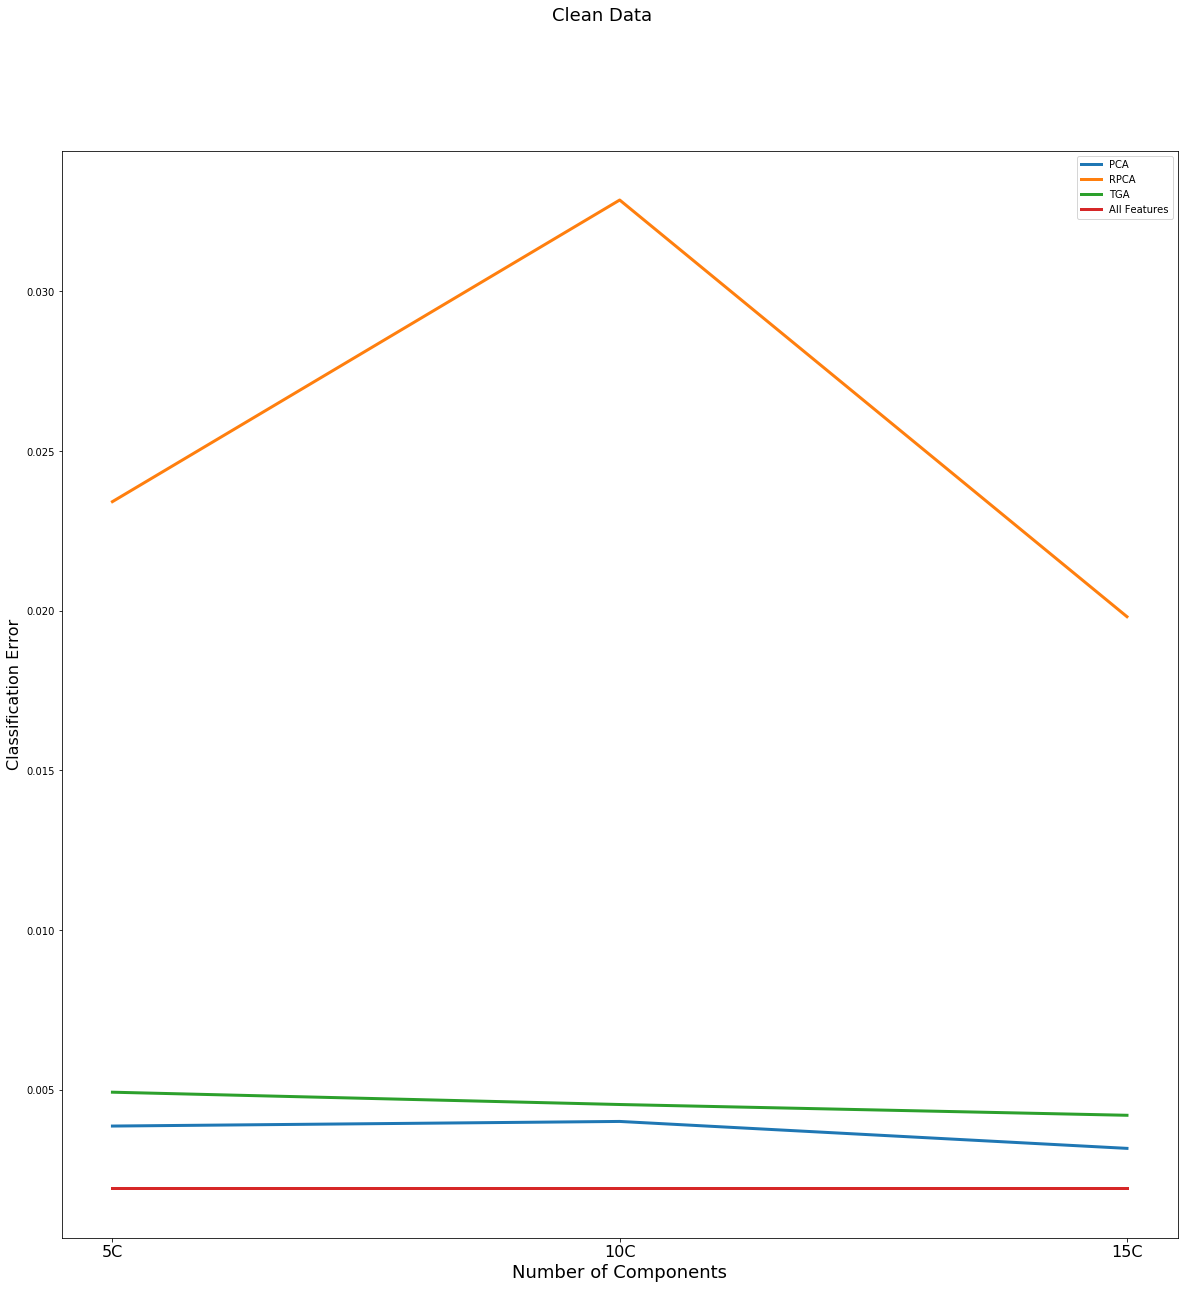

In [517]:
import matplotlib
matplotlib.rcParams.update({'errorbar.capsize': 10})
fig,ax = plt.subplots()
fig.set_size_inches(20,20)


ax.errorbar([1,2,3],[i.mean() for i in clean_score_pca],label="PCA",lw=3)
ax.errorbar([1,2,3],[i.mean() for i in clean_score_rpca],label="RPCA",lw=3)
ax.errorbar([1,2,3],[i.mean() for i in clean_score_ica],label="TGA",lw=3)
ax.errorbar([1,2,3],[1-np.array(original_rs).mean()]*3,label="All Features",lw=3)

ax.set_xticks([1,2,3])
ax.set_xticklabels(('5C','10C','15C'),fontsize=16)

plt.legend()
# plt.figure()
fig.suptitle('Clean Data', fontsize=18)
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/clean_result.png')

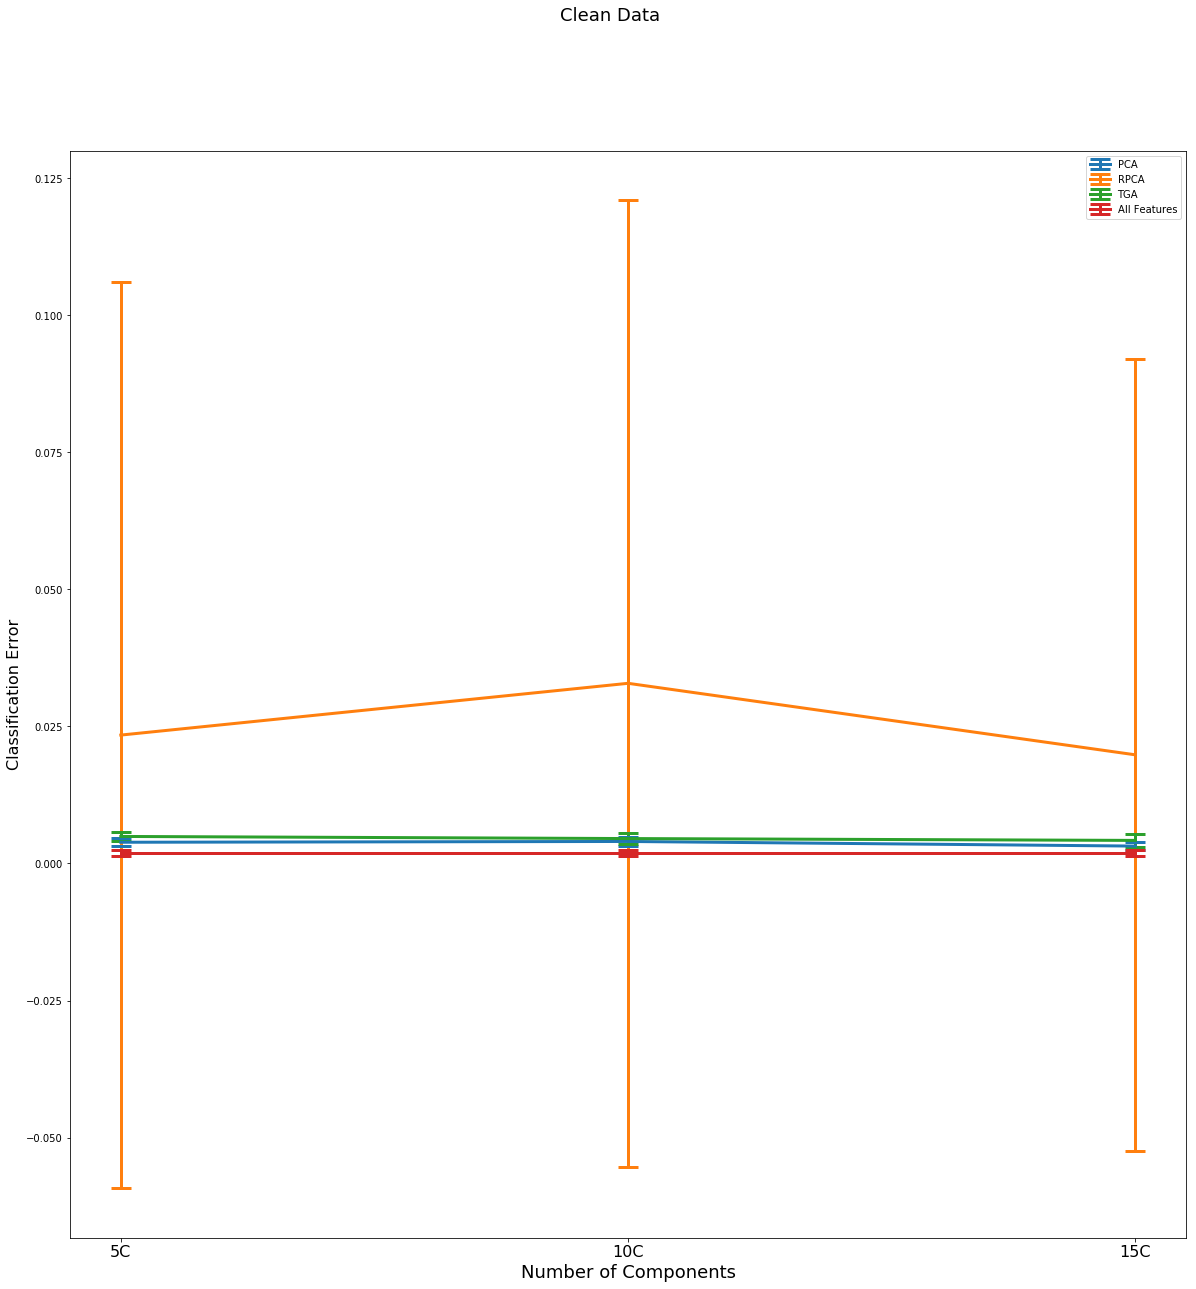

In [516]:
import matplotlib
matplotlib.rcParams.update({'errorbar.capsize': 10})
fig,ax = plt.subplots()
fig.set_size_inches(20,20)


ax.errorbar([1,2,3],[i.mean() for i in clean_score_pca],label="PCA",lw=3,yerr=[i.std() for i in clean_score_pca],capthick=3)
ax.errorbar([1,2,3],[i.mean() for i in clean_score_rpca],label="RPCA",lw=3,yerr=[i.std() for i in clean_score_rpca],capthick=3)
ax.errorbar([1,2,3],[i.mean() for i in clean_score_ica],label="TGA",lw=3,yerr=[i.std() for i in clean_score_ica],capthick=3)
ax.errorbar([1,2,3],[1-np.array(original_rs).mean()]*3,label="All Features",lw=3,yerr=[(1-np.array(original_rs)).std()]*3,capthick=3)

ax.set_xticks([1,2,3])
ax.set_xticklabels(('5C','10C','15C'),fontsize=16)

plt.legend()
# plt.figure()
fig.suptitle('Clean Data', fontsize=18)
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/clean_result_errbar.png')

In [420]:
# clean_pca_mean = [(1 - np.array(i)).mean() for i in clean_score_rpca]
# clean_pca_std = [np.std(1-np.array(i)) for i in clean_score_rpca]
# components = ['5C','10C','15C']
# x_pos = np.arange(len(components))
# CTEs = clean_pca_mean
# error = clean_pca_std

In [485]:
# fig, ax = plt.subplots()
# ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
# ax.set_ylabel('Error rate (%)')
# ax.set_xticks(x_pos)
# ax.set_xticklabels(components)
# ax.set_title('Number of Components')
# ax.yaxis.grid(True)

# # Save the figure and show
# plt.tight_layout()
# # plt.savefig('bar_plot_with_error_bars.png')
# plt.show()

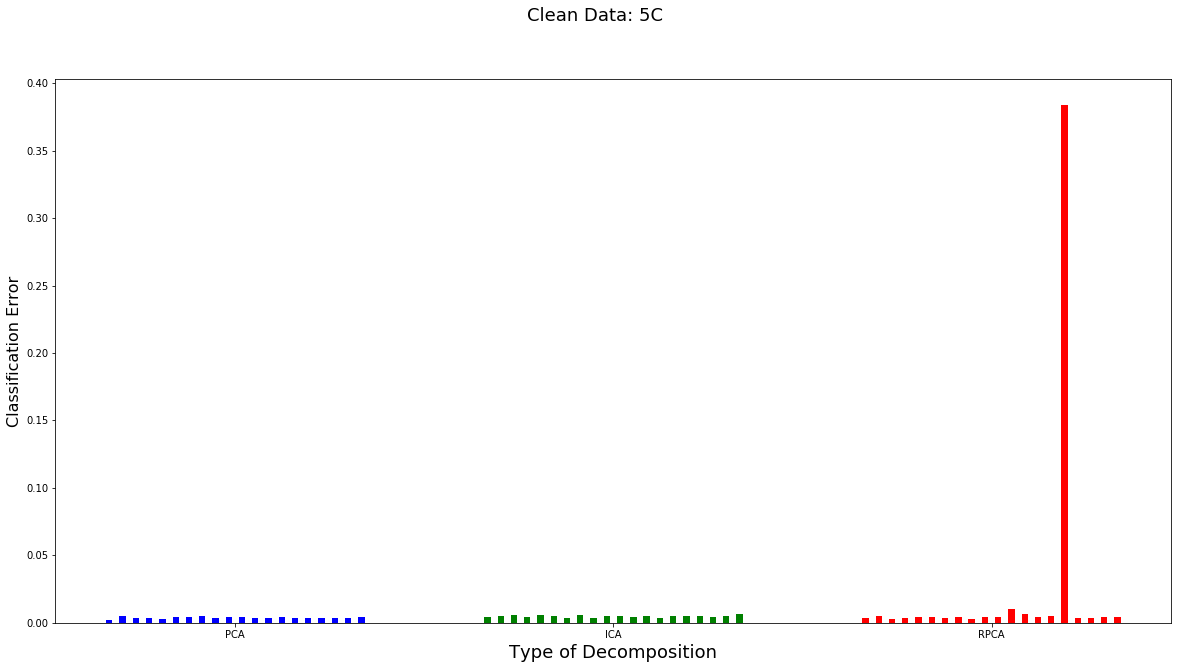

In [489]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.bar(np.linspace(1,2,len(clean_score_pca[0])),clean_score_pca[0], color = 'b', width = 0.5/len(clean_score_pca[0]))
ax.bar(np.linspace(2.5,3.5,len(clean_score_ica[0])),clean_score_ica[0], color = 'g', width = 0.5/len(clean_score_ica[0]))

ax.bar(np.linspace(4,5,len(clean_score_rpca[0])),clean_score_rpca[0], color = 'r', width = 0.5/len(clean_score_rpca[0]))

ax.set_xticks([1.5,3.0,4.5])
ax.set_xticklabels(('PCA','ICA','RPCA'),fontsize=18)

fig.suptitle('Clean Data: 5C', fontsize=18)
plt.xlabel('Type of Decomposition', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/clean_5C_result.png')

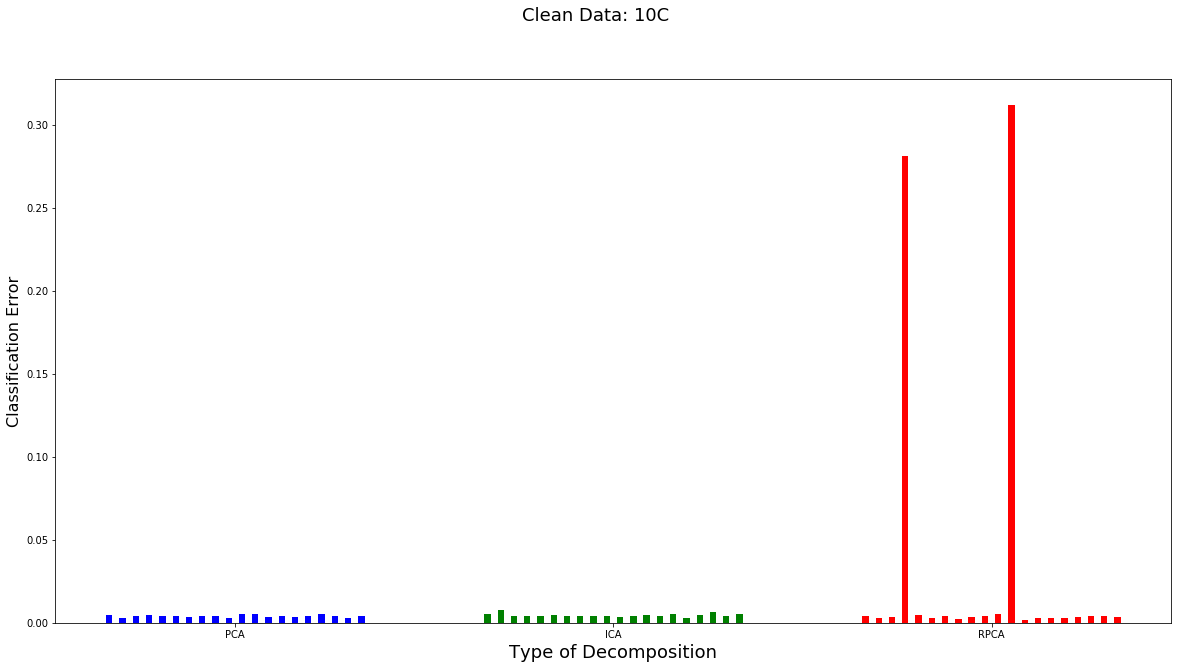

In [490]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.bar(np.linspace(1,2,len(clean_score_pca[1])), clean_score_pca[1], color = 'b', width = 0.5/len(clean_score_pca[1]))
ax.bar(np.linspace(2.5,3.5,len(clean_score_ica[1])), clean_score_ica[1], color = 'g', width = 0.5/len(clean_score_ica[1]))

ax.bar(np.linspace(4,5,len(clean_score_rpca[1])), clean_score_rpca[1], color = 'r', width = 0.5/len(clean_score_rpca[1]))

ax.set_xticks([1.5,3.0,4.5])
ax.set_xticklabels(('PCA','ICA','RPCA'),fontsize=18);

fig.suptitle('Clean Data: 10C', fontsize=18)
plt.xlabel('Type of Decomposition', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/clean_10C_result.png')

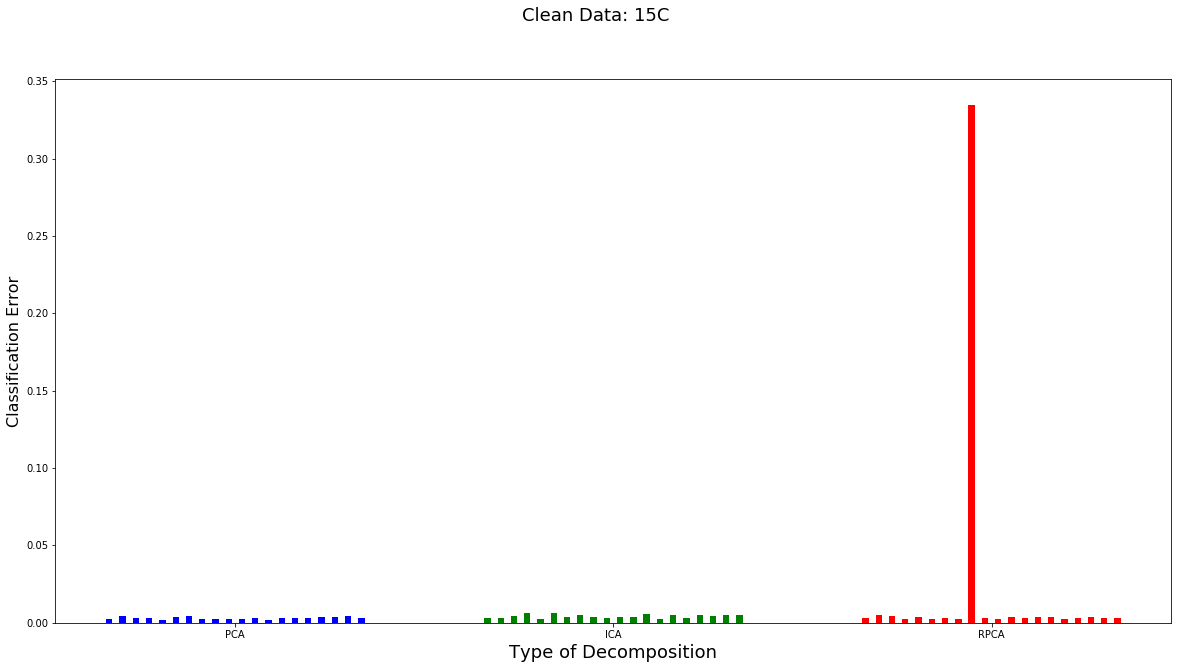

In [491]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.bar(np.linspace(1,2,len(clean_score_pca[2])), clean_score_pca[2], color = 'b', width = 0.5/len(clean_score_pca[2]))
ax.bar(np.linspace(2.5,3.5,len(clean_score_ica[2])), clean_score_ica[2], color = 'g', width = 0.5/len(clean_score_ica[2]))

ax.bar(np.linspace(4,5,len(clean_score_rpca[2])), clean_score_rpca[2], color = 'r', width = 0.5/len(clean_score_rpca[2]))

ax.set_xticks([1.5,3.0,4.5])
ax.set_xticklabels(('PCA','ICA','RPCA'),fontsize=18);

fig.suptitle('Clean Data: 15C', fontsize=18)
plt.xlabel('Type of Decomposition', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/clean_15C_result.png')

0.383762948687
0.281618887015
0.312213924356
0.334618164298


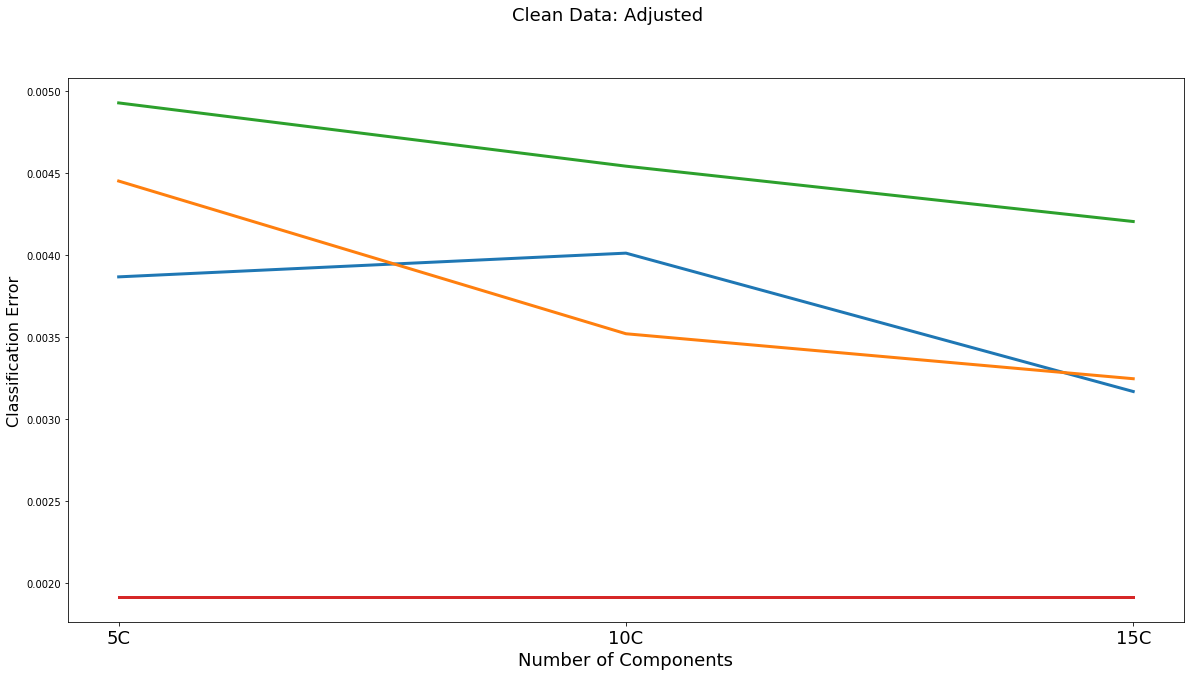

In [525]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.set_xticks([1,2,3])
ax.set_xticklabels(('5C','10C','15C'),fontsize=18)

ax.errorbar([1,2,3],[i.mean() for i in cal_error(clean_score_pca)],label="PCA",lw=3)
ax.errorbar([1,2,3],[i.mean() for i in cal_error(clean_score_rpca,0.2)],label="RPCA",lw=3)
ax.errorbar([1,2,3],[i.mean() for i in cal_error(clean_score_ica)],label="ICA",lw=3)
ax.errorbar([1,2,3],[1-np.array(original_rs).mean()]*3,label="All Features",lw=3)
# plt.figure()
fig.suptitle('Clean Data: Adjusted', fontsize=18)
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/clean_adjusted_result.png')

0.383762948687
0.281618887015
0.312213924356
0.334618164298
0.383762948687
0.281618887015
0.312213924356
0.334618164298


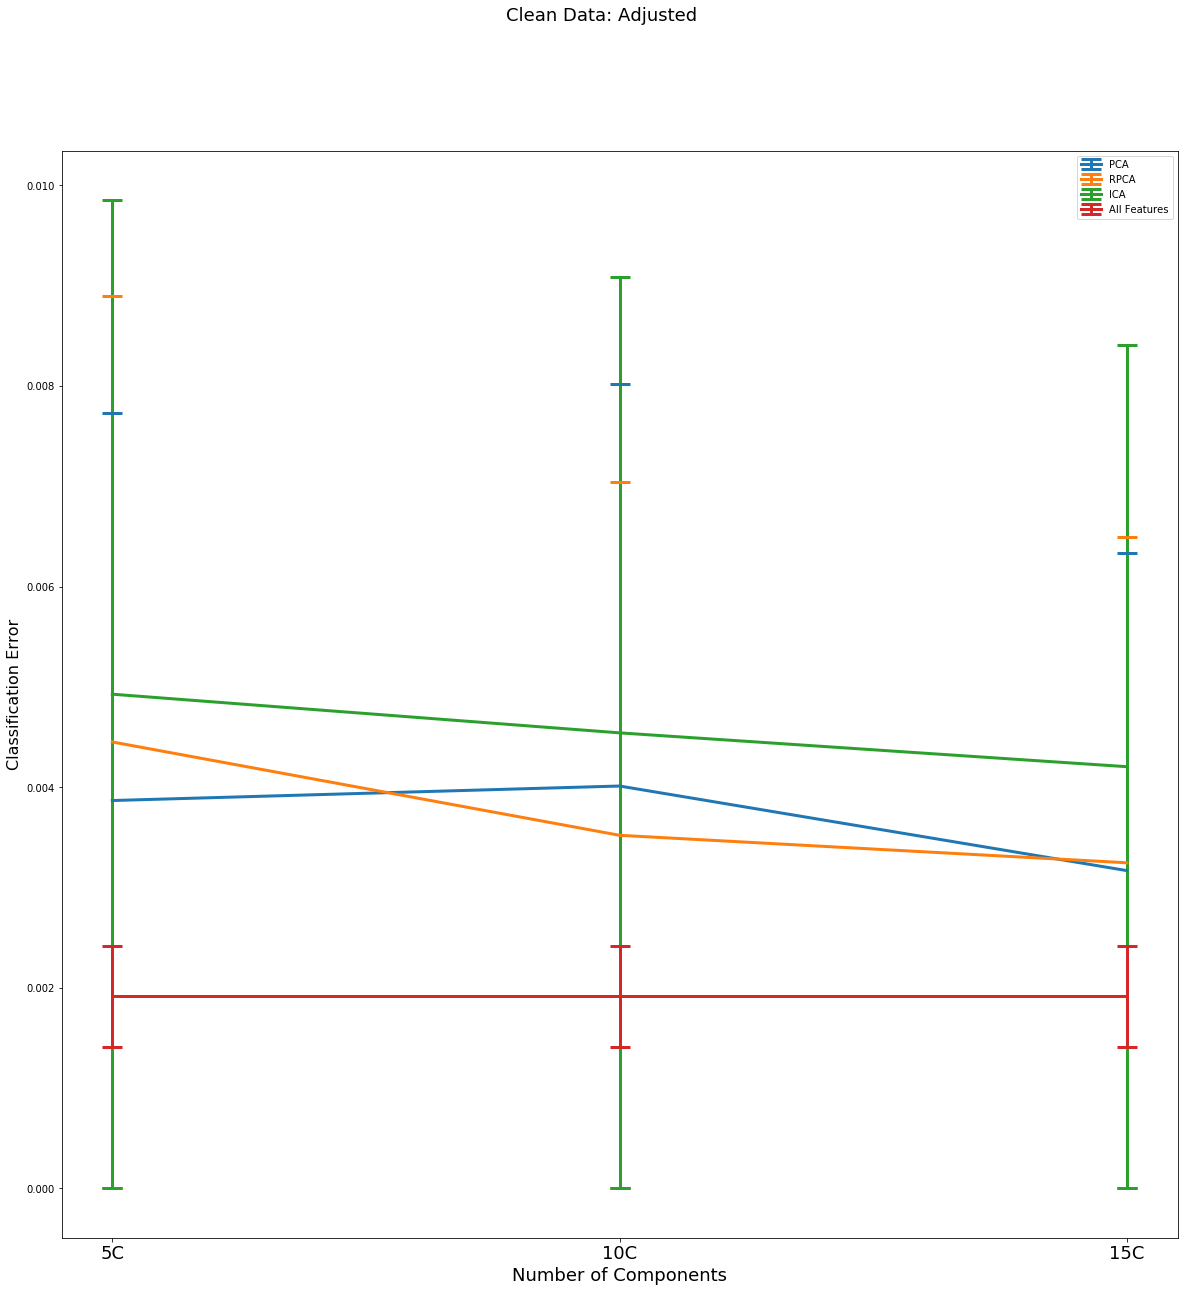

In [577]:
fig,ax = plt.subplots()
fig.set_size_inches(20,20)

ax.set_xticks([1,2,3])
ax.set_xticklabels(('5C','10C','15C'),fontsize=18)

ax.errorbar([1,2,3],[i.mean() for i in cal_error(clean_score_pca)],label="PCA",yerr=[i.mean() for i in cal_error(clean_score_pca)],lw=3,capthick=3)
ax.errorbar([1,2,3],[i.mean() for i in cal_error(clean_score_rpca,0.2)],yerr=[i.mean() for i in cal_error(clean_score_rpca,0.2)],label="RPCA",lw=3,capthick=3)
ax.errorbar([1,2,3],[i.mean() for i in cal_error(clean_score_ica)],label="ICA",yerr=[i.mean() for i in cal_error(clean_score_ica)],lw=3,capthick=3)
ax.errorbar([1,2,3],[1-np.array(original_rs).mean()]*3,label="All Features",lw=3,yerr=[(1-np.array(original_rs)).std()]*3,capthick=3)


plt.legend()
# plt.figure()
fig.suptitle('Clean Data: Adjusted', fontsize=18)
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/clean_adjusted_result_errbar.png')

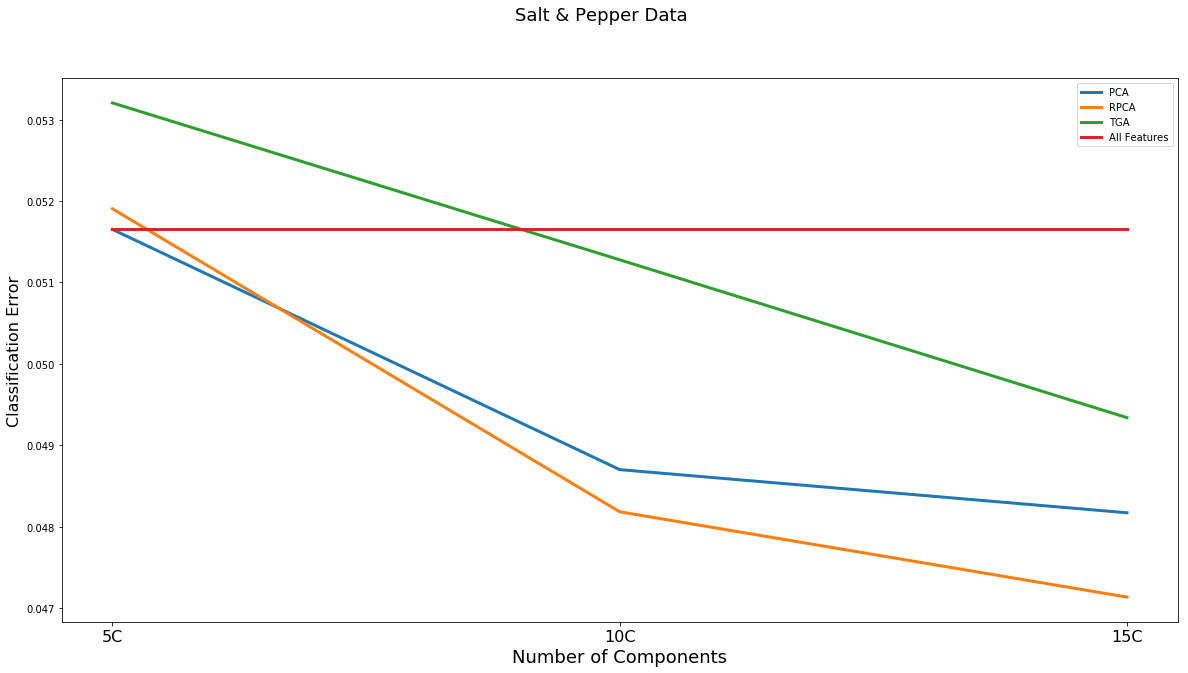

In [529]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.errorbar([1,2,3],[i.mean() for i in salted_score_pca],label="PCA",lw=3)
ax.errorbar([1,2,3],[i.mean() for i in salted_score_rpca],label="RPCA",lw=3)
ax.errorbar([1,2,3],[i.mean() for i in salted_score_ica],label="TGA",lw=3)
ax.errorbar([1,2,3],[1-np.array(salted_original_rs).mean()]*3,label="All Features",lw=3)

ax.set_xticks([1,2,3])
ax.set_xticklabels(('5C','10C','15C'),fontsize=16)

ax.legend()
# plt.figure()

fig.suptitle('Salt & Pepper Data', fontsize=18)
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/salt_result.png')

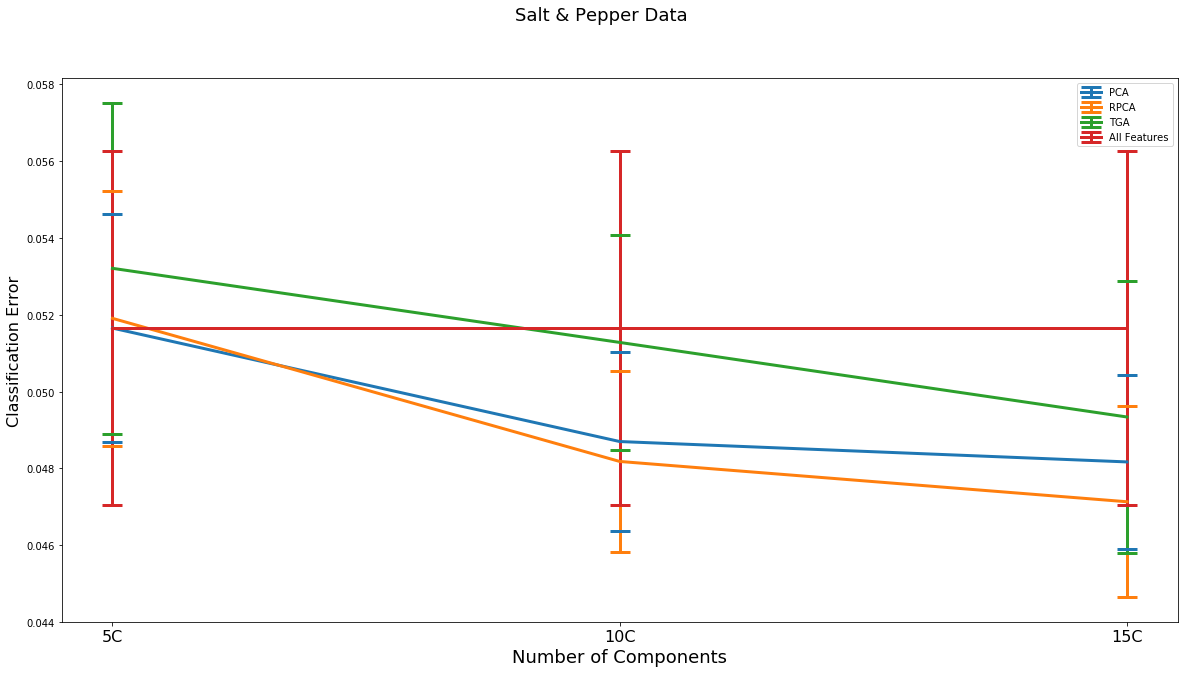

In [531]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.set_xticks([1,2,3])
ax.set_xticklabels(('5C','10C','15C'),fontsize=18)

ax.errorbar([1,2,3],[i.mean() for i in salted_score_pca],label="PCA",lw=3,yerr=[i.std() for i in salted_score_pca],capthick=3)
ax.errorbar([1,2,3],[i.mean() for i in salted_score_rpca],label="RPCA",lw=3,yerr=[i.std() for i in salted_score_rpca],capthick=3)
ax.errorbar([1,2,3],[i.mean() for i in salted_score_ica],label="TGA",lw=3,yerr=[i.std() for i in salted_score_ica],capthick=3)
ax.errorbar([1,2,3],[1-np.array(salted_original_rs).mean()]*3,label="All Features",lw=3,yerr=[(1-np.array(salted_original_rs)).std()]*3,capthick=3)


ax.legend()
# plt.figure()

fig.suptitle('Salt & Pepper Data', fontsize=18)
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/salt_result_errbar.png')

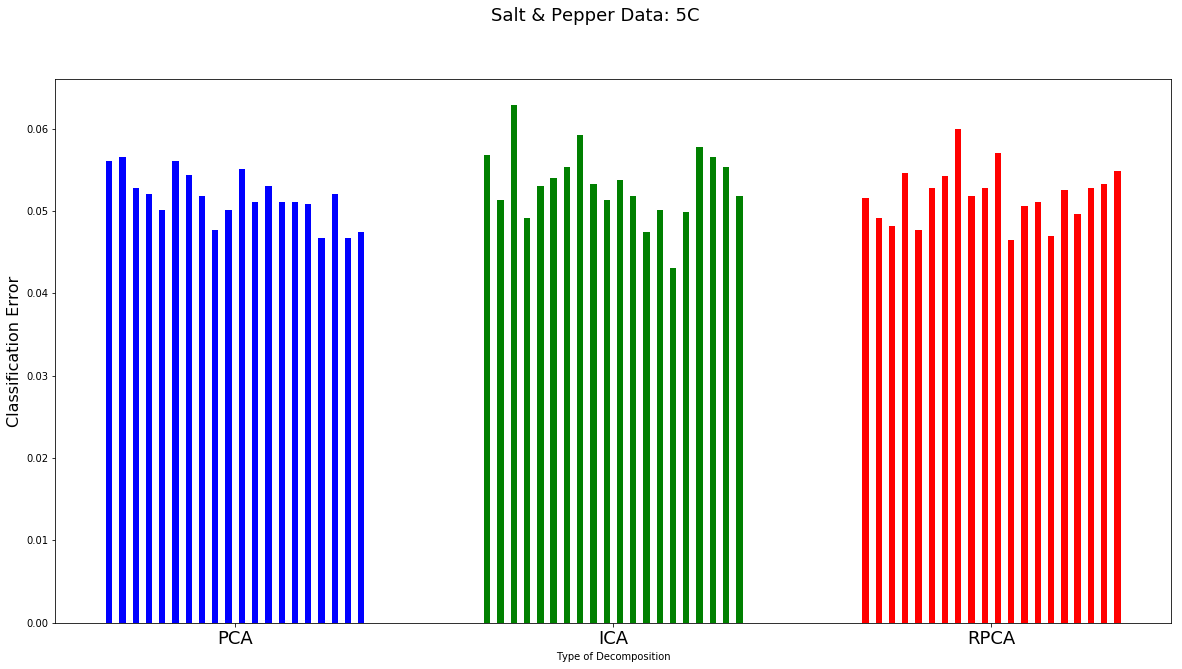

In [533]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.bar(np.linspace(1,2,len(salted_score_pca[0])),salted_score_pca[0], color = 'b', width = 0.5/len(salted_score_pca[0]))
ax.bar(np.linspace(2.5,3.5,len(salted_score_ica[0])),salted_score_ica[0], color = 'g', width = 0.5/len(salted_score_ica[0]))
ax.bar(np.linspace(4,5,len(salted_score_rpca[0])),salted_score_rpca[0], color = 'r', width = 0.5/len(salted_score_rpca[0]))

ax.set_xticks([1.5,3.0,4.5])
ax.set_xticklabels(('PCA','ICA','RPCA'),fontsize=18);
fig.suptitle('Salt & Pepper Data: 5C', fontsize=18)
plt.xlabel('Type of Decomposition',)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/salt_5C_result.png')

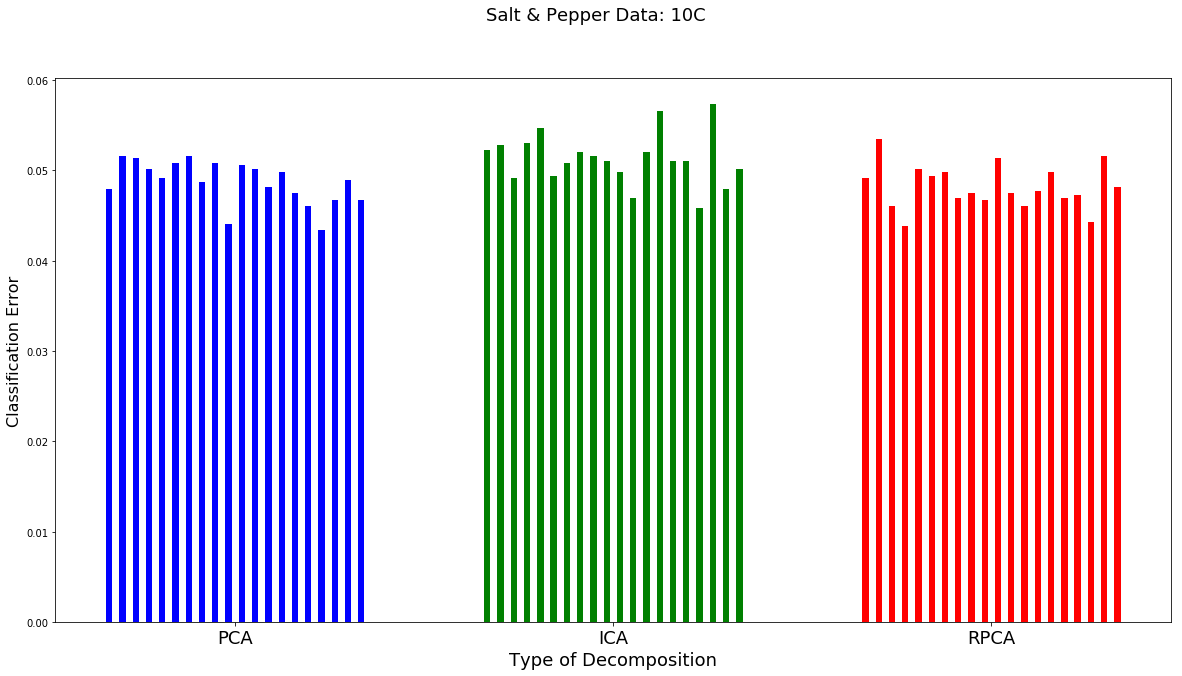

In [535]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.bar(np.linspace(1,2,len(salted_score_pca[1])),salted_score_pca[1], color = 'b', width = 0.5/len(salted_score_pca[1]))
ax.bar(np.linspace(2.5,3.5,len(salted_score_ica[1])),salted_score_ica[1], color = 'g', width = 0.5/len(salted_score_ica[1]))
ax.bar(np.linspace(4,5,len(salted_score_rpca[1])),salted_score_rpca[1], color = 'r', width = 0.5/len(salted_score_rpca[1]))

ax.set_xticks([1.5,3.0,4.5])
ax.set_xticklabels(('PCA','ICA','RPCA'),fontsize=18);

fig.suptitle('Salt & Pepper Data: 10C', fontsize=18)
plt.xlabel('Type of Decomposition', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/salt_10C_result.png')

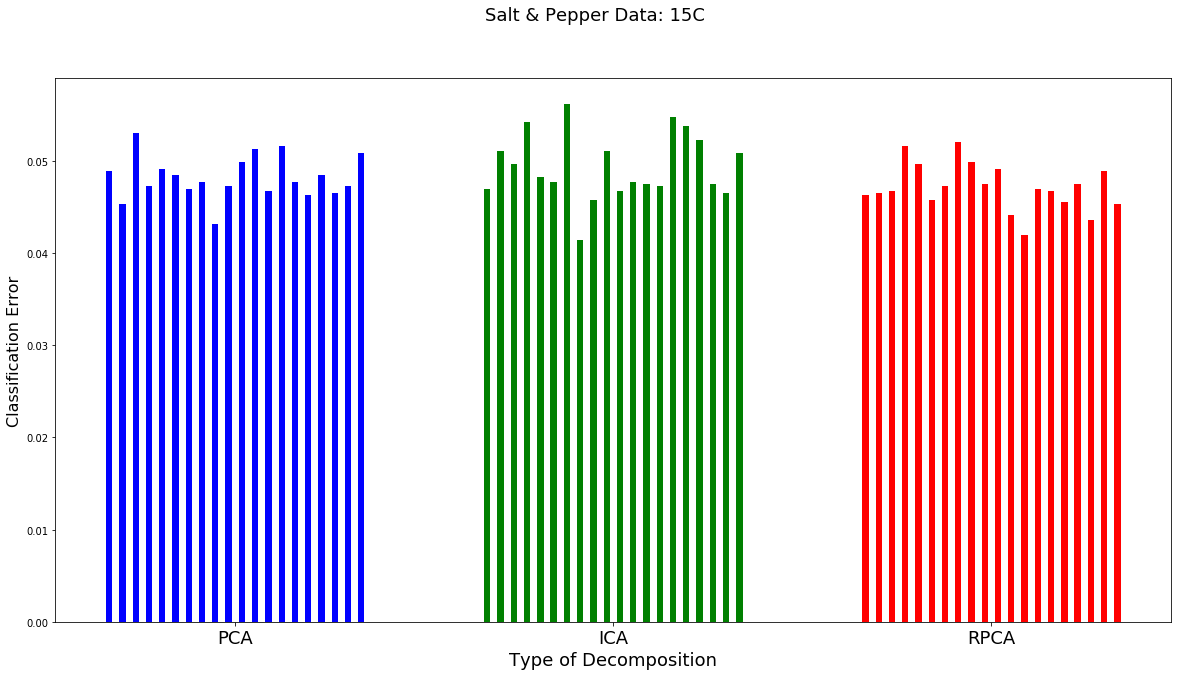

In [536]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.bar(np.linspace(1,2,len(salted_score_pca[2])),salted_score_pca[2], color = 'b', width = 0.5/len(salted_score_pca[2]))
ax.bar(np.linspace(2.5,3.5,len(salted_score_ica[2])),salted_score_ica[2], color = 'g', width = 0.5/len(salted_score_ica[2]))
ax.bar(np.linspace(4,5,len(salted_score_rpca[2])),salted_score_rpca[2], color = 'r', width = 0.5/len(salted_score_rpca[2]))

ax.set_xticks([1.5,3.0,4.5])
ax.set_xticklabels(('PCA','ICA','RPCA'),fontsize=18);

fig.suptitle('Salt & Pepper Data: 15C', fontsize=18)
plt.xlabel('Type of Decomposition', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/salt_15C_result.png')

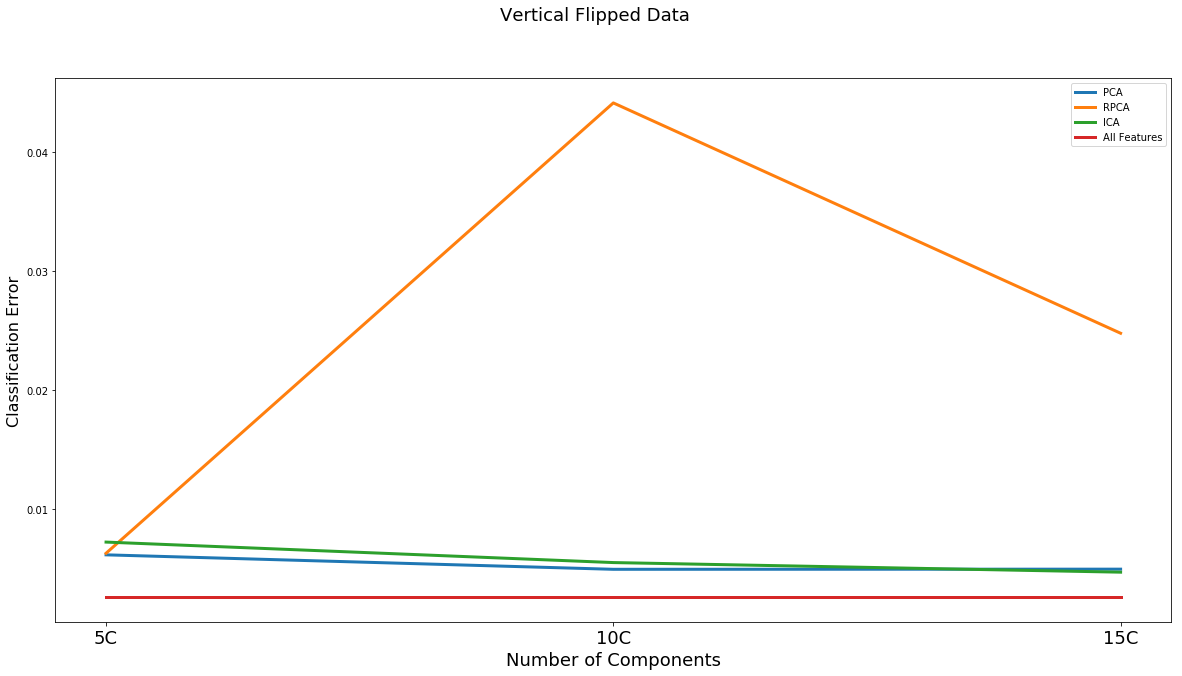

In [539]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.set_xticks([1,2,3])
ax.set_xticklabels(('5C','10C','15C'),fontsize=18)

ax.plot([1,2,3],[i.mean() for i in vert_score_pca],label="PCA",lw=3)
ax.plot([1,2,3],[i.mean() for i in vert_score_rpca],label="RPCA",lw=3)
ax.plot([1,2,3],[i.mean() for i in vert_score_ica],label="ICA",lw=3)
ax.plot([1,2,3],[1-np.array(vert_flip_original_rs).mean()]*3,label="All Features",lw=3)

ax.legend()
# plt.figure()

fig.suptitle('Vertical Flipped Data', fontsize=18)
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/vert_result.png')

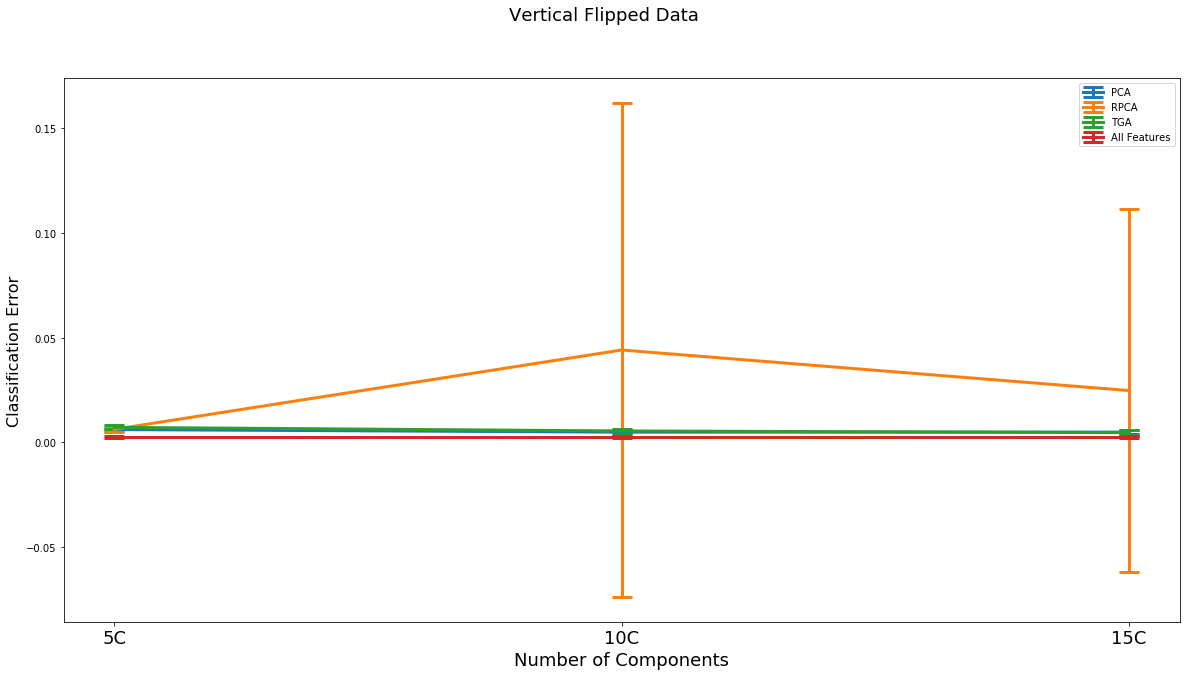

In [538]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.set_xticks([1,2,3])
ax.set_xticklabels(('5C','10C','15C'),fontsize=18)

ax.errorbar([1,2,3],[i.mean() for i in vert_score_pca],label="PCA",lw=3,yerr=[i.std() for i in vert_score_pca],capthick=3)
ax.errorbar([1,2,3],[i.mean() for i in vert_score_rpca],label="RPCA",lw=3,yerr=[i.std() for i in vert_score_rpca],capthick=3)
ax.errorbar([1,2,3],[i.mean() for i in vert_score_ica],label="TGA",lw=3,yerr=[i.std() for i in vert_score_ica],capthick=3)
ax.errorbar([1,2,3],[1-np.array(vert_flip_original_rs).mean()]*3,label="All Features",lw=3,yerr=[(1-np.array(vert_flip_original_rs)).std()]*3,capthick=3)


ax.legend()
# plt.figure()

fig.suptitle('Vertical Flipped Data', fontsize=18)
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/vert_result_errbar.png')

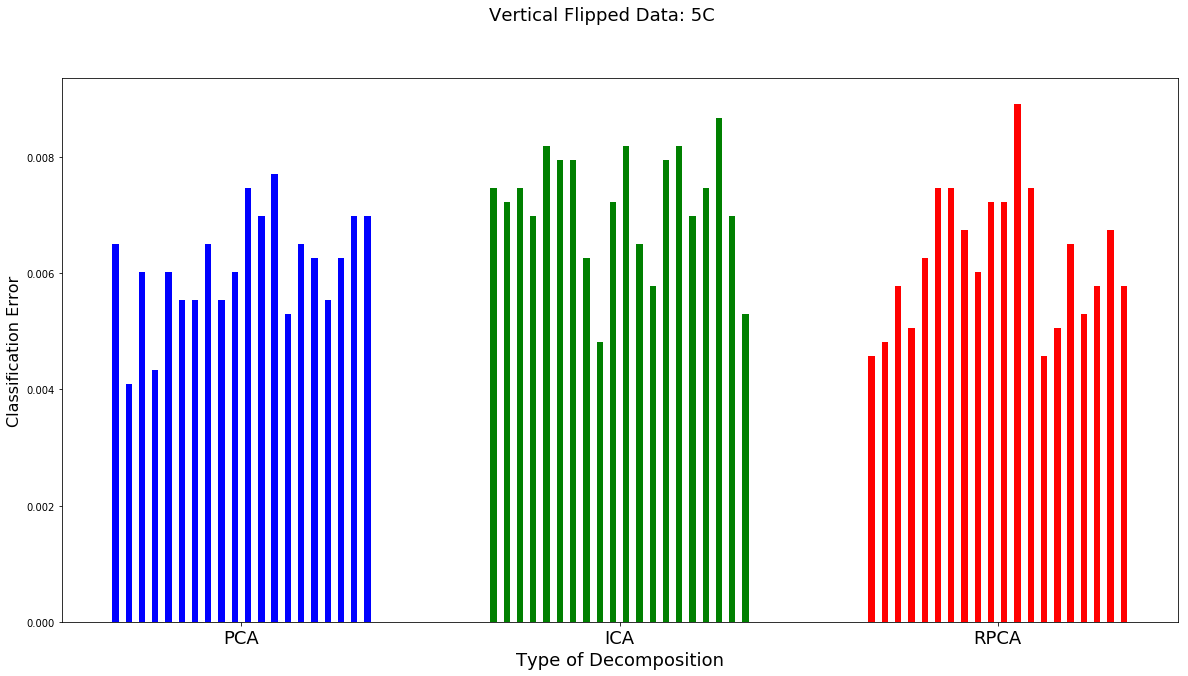

In [540]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.bar(np.linspace(1,2,len(vert_score_pca[0])),vert_score_pca[0], color = 'b', width = 0.5/len(vert_score_pca[0]))
ax.bar(np.linspace(2.5,3.5,len(vert_score_ica[0])),vert_score_ica[0], color = 'g', width = 0.5/len(vert_score_ica[0]))
ax.bar(np.linspace(4,5,len(vert_score_rpca[0])),vert_score_rpca[0], color = 'r', width = 0.5/len(vert_score_rpca[0]))

ax.set_xticks([1.5,3.0,4.5])
ax.set_xticklabels(('PCA','ICA','RPCA'),fontsize=18);

fig.suptitle('Vertical Flipped Data: 5C', fontsize=18)
plt.xlabel('Type of Decomposition', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/vert_5C_result.png')

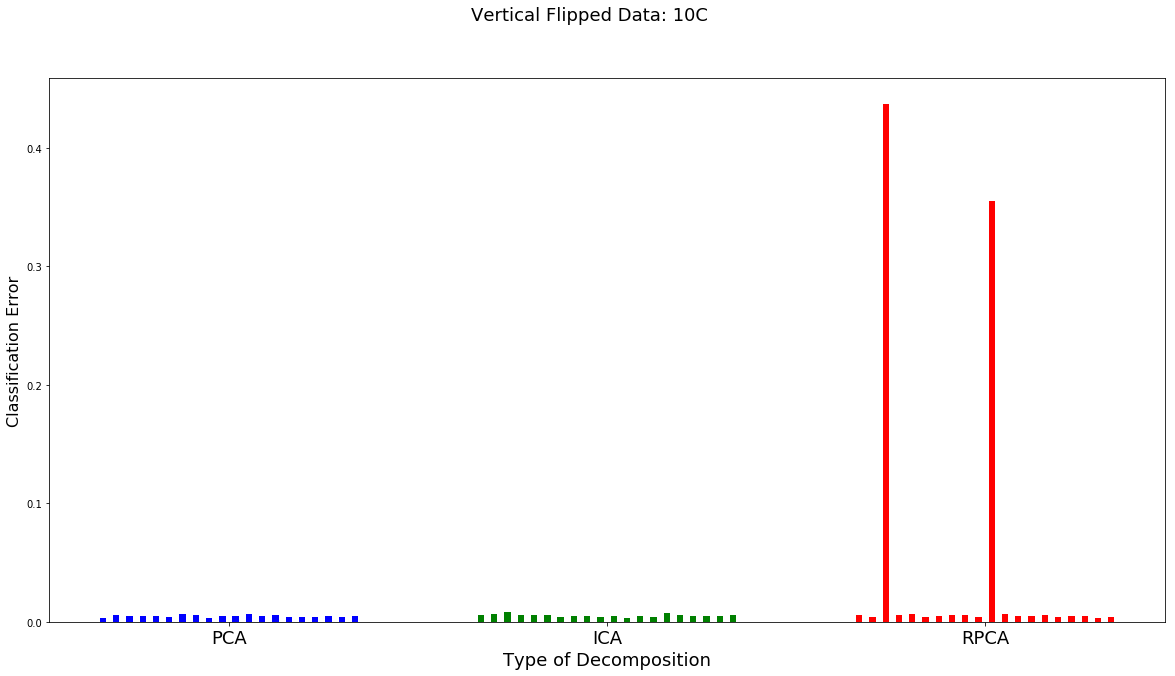

In [541]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.bar(np.linspace(1,2,len(vert_score_pca[1])), vert_score_pca[1], color = 'b', width = 0.5/len(vert_score_pca[1]))
ax.bar(np.linspace(2.5,3.5,len(vert_score_ica[1])), vert_score_ica[1], color = 'g', width = 0.5/len(vert_score_ica[1]))
ax.bar(np.linspace(4,5,len(vert_score_rpca[1])), vert_score_rpca[1], color = 'r', width = 0.5/len(vert_score_rpca[1]))

ax.set_xticks([1.5,3.0,4.5])
ax.set_xticklabels(('PCA','ICA','RPCA'),fontsize=18);

fig.suptitle('Vertical Flipped Data: 10C', fontsize=18)
plt.xlabel('Type of Decomposition', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/vert_10C_result.png')

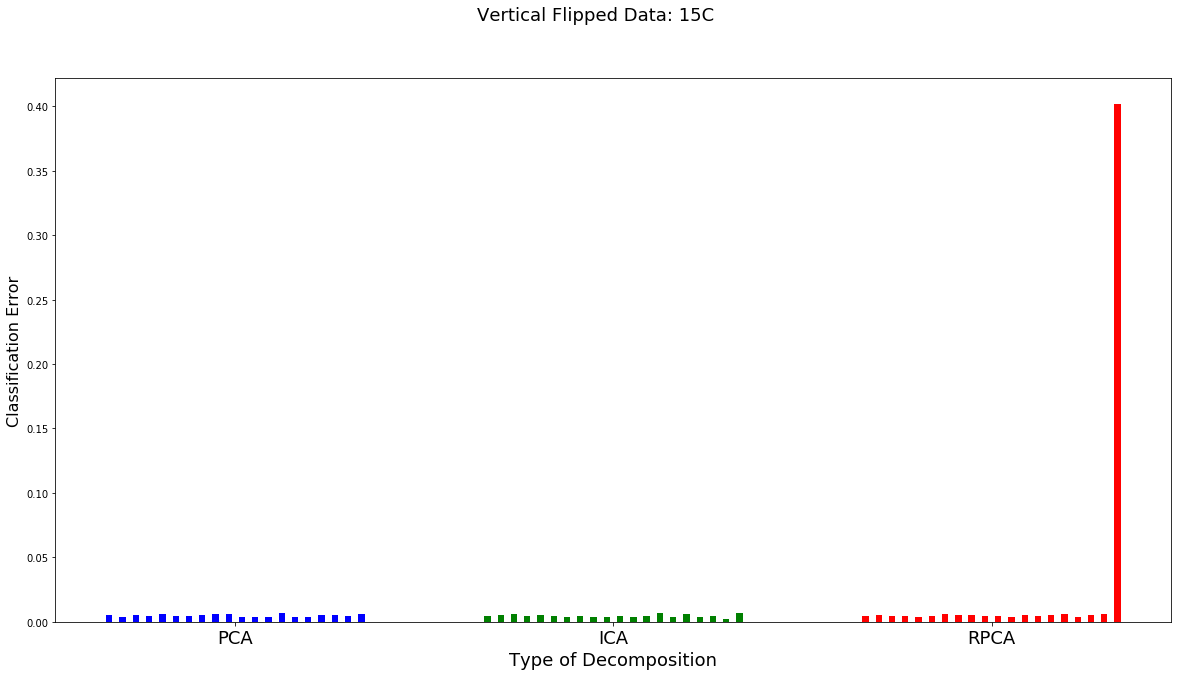

In [542]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.bar(np.linspace(1,2,len(vert_score_pca[2])), vert_score_pca[2], color = 'b', width = 0.5/len(vert_score_pca[2]))
ax.bar(np.linspace(2.5,3.5,len(vert_score_ica[2])), vert_score_ica[2], color = 'g', width = 0.5/len(vert_score_ica[2]))
ax.bar(np.linspace(4,5,len(vert_score_rpca[2])), vert_score_rpca[2], color = 'r', width = 0.5/len(vert_score_rpca[2]))

ax.set_xticks([1.5,3.0,4.5])
ax.set_xticklabels(('PCA','ICA','RPCA'),fontsize=18);

fig.suptitle('Vertical Flipped Data: 15C', fontsize=18)
plt.xlabel('Type of Decomposition', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/vert_15C_result.png')

0.43676222597
0.355095157793
0.401589978318


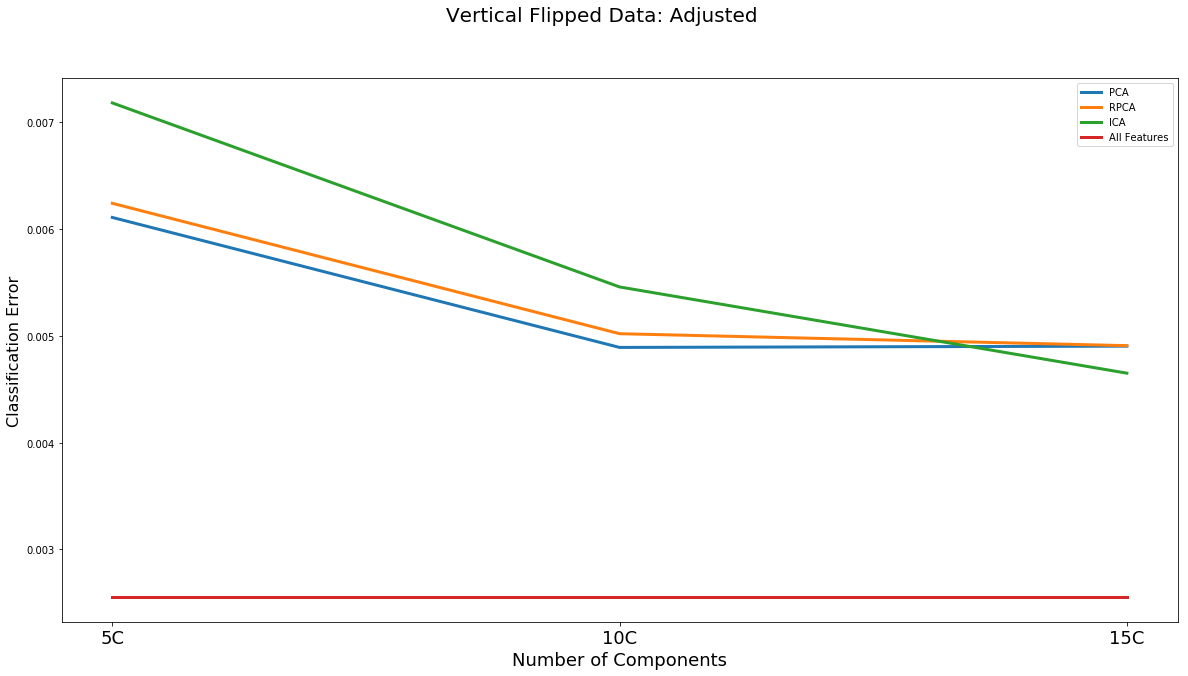

In [578]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.set_xticks([1,2,3])
ax.set_xticklabels(('5C','10C','15C'),fontsize=18)

ax.errorbar([1,2,3],[i.mean() for i in cal_error(vert_score_pca)],label="PCA",lw=3)
ax.errorbar([1,2,3],[i.mean() for i in cal_error(vert_score_rpca,0.2)],label="RPCA",lw=3)
ax.errorbar([1,2,3],[i.mean() for i in cal_error(vert_score_ica)],label="ICA",lw=3)
ax.errorbar([1,2,3],[1-np.array(vert_flip_original_rs).mean()]*3,label="All Features",lw=3)


ax.legend()
# plt.figure()
fig.suptitle('Vertical Flipped Data: Adjusted', fontsize=20)
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/vert_adjusted_result.png')

0.43676222597
0.355095157793
0.401589978318
0.43676222597
0.355095157793
0.401589978318


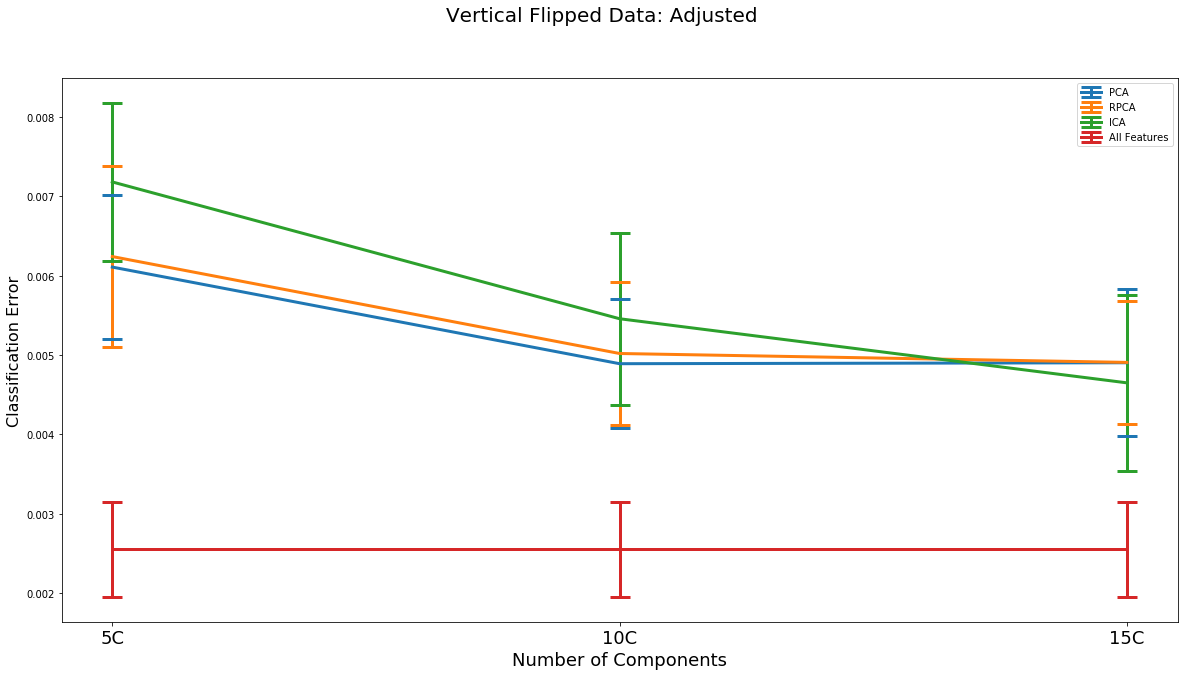

In [560]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.set_xticks([1,2,3])
ax.set_xticklabels(('5C','10C','15C'),fontsize=18)

ax.errorbar([1,2,3],[i.mean() for i in cal_error(vert_score_pca)],label="PCA",yerr=[i.std() for i in cal_error(vert_score_pca)],lw=3,capthick=3)
ax.errorbar([1,2,3],[i.mean() for i in cal_error(vert_score_rpca,0.2)],yerr=[i.std() for i in cal_error(vert_score_rpca,0.2)],label="RPCA",lw=3,capthick=3)
ax.errorbar([1,2,3],[i.mean() for i in cal_error(vert_score_ica)],label="ICA",yerr=[i.std() for i in cal_error(vert_score_ica)],lw=3,capthick=3)
ax.errorbar([1,2,3],[1-np.array(vert_flip_original_rs).mean()]*3,label="All Features",lw=3,yerr=[(1-np.array(vert_flip_original_rs)).std()]*3,capthick=3)


ax.legend()
# plt.figure()
fig.suptitle('Vertical Flipped Data: Adjusted', fontsize=20)
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/vert_adjusted_result_errbar.png')

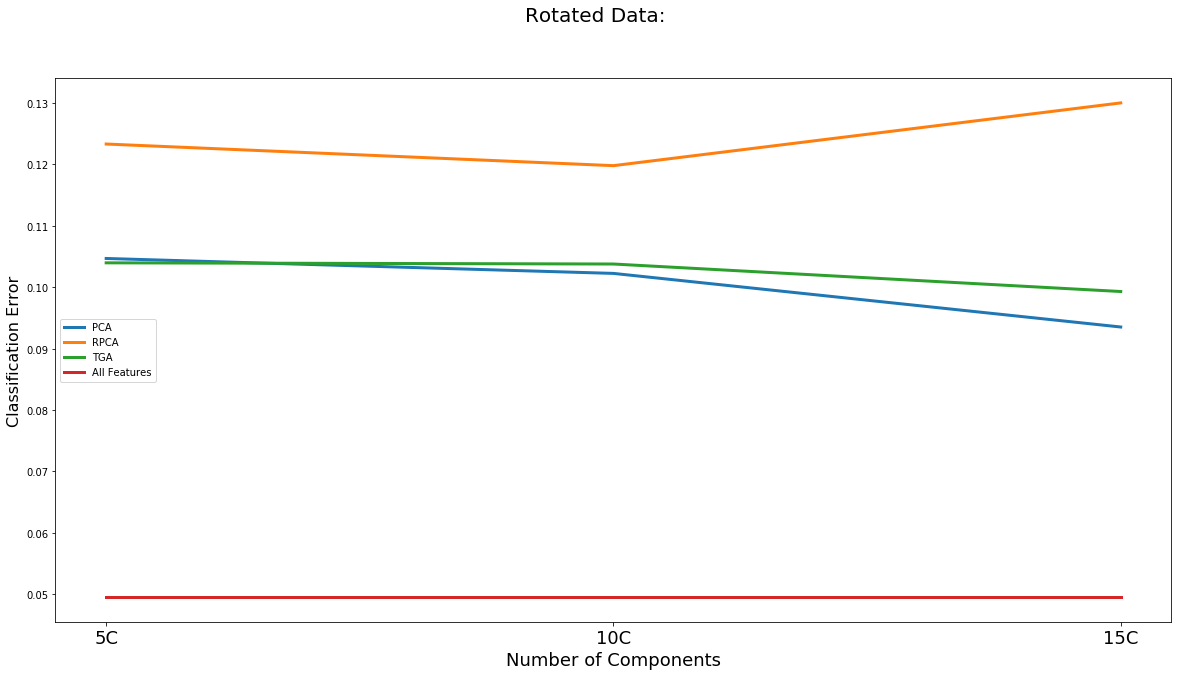

In [554]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.set_xticks([1,2,3])
ax.set_xticklabels(('5C','10C','15C'),fontsize=18)


ax.errorbar([1,2,3],[i.mean() for i in rotate_score_pca],label="PCA",lw=3)
ax.errorbar([1,2,3],[i.mean() for i in rotate_score_rpca],label="RPCA",lw=3)
ax.errorbar([1,2,3],[i.mean() for i in rotate_score_ica],label="TGA",lw=3)
ax.errorbar([1,2,3],[1-np.array(rotate_original_rs).mean()]*3,label="All Features",lw=3)


ax.legend()
# plt.figure()

fig.suptitle('Rotated Data:', fontsize=20)
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/rotated_result.png')

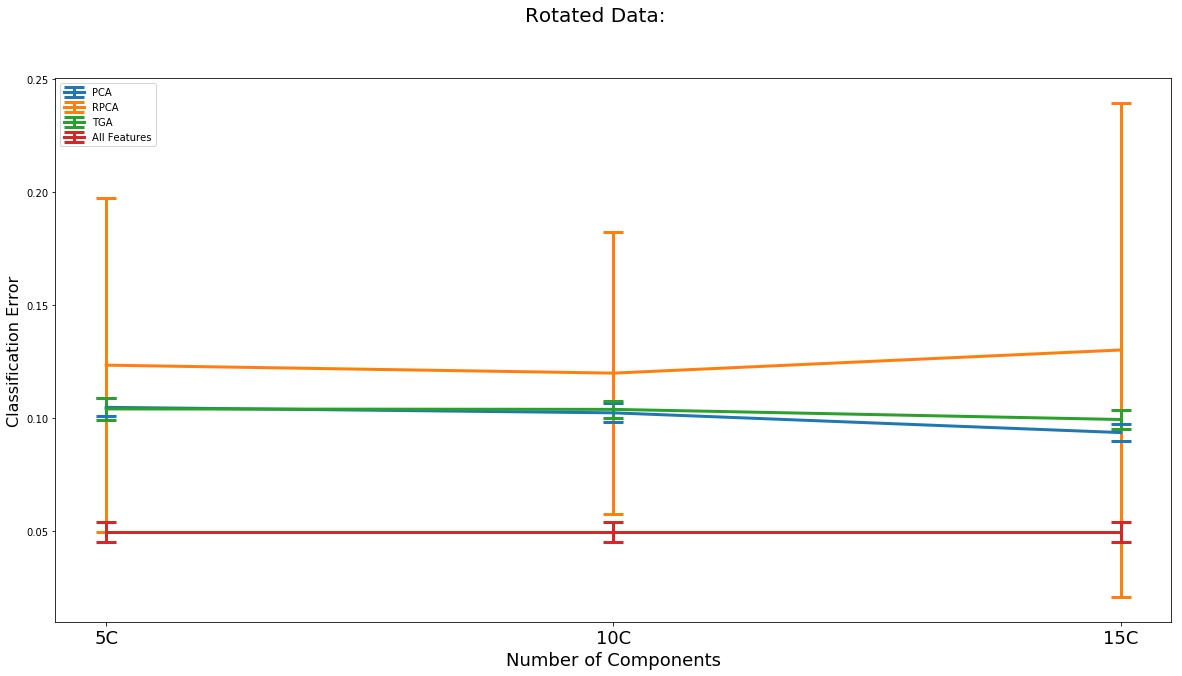

In [555]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.set_xticks([1,2,3])
ax.set_xticklabels(('5C','10C','15C'),fontsize=18)


ax.errorbar([1,2,3],[i.mean() for i in rotate_score_pca],label="PCA",lw=3,yerr=[i.std() for i in rotate_score_pca],capthick=3)
ax.errorbar([1,2,3],[i.mean() for i in rotate_score_rpca],label="RPCA",lw=3,yerr=[i.std() for i in rotate_score_rpca],capthick=3)
ax.errorbar([1,2,3],[i.mean() for i in rotate_score_ica],label="TGA",lw=3,yerr=[i.std() for i in rotate_score_ica],capthick=3)
ax.errorbar([1,2,3],[1-np.array(rotate_original_rs).mean()]*3,label="All Features",lw=3,yerr=[(1-np.array(rotate_original_rs)).std()]*3,capthick=3)


ax.legend()
# plt.figure()

fig.suptitle('Rotated Data:', fontsize=20)
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/rotated_result_errbar.png')

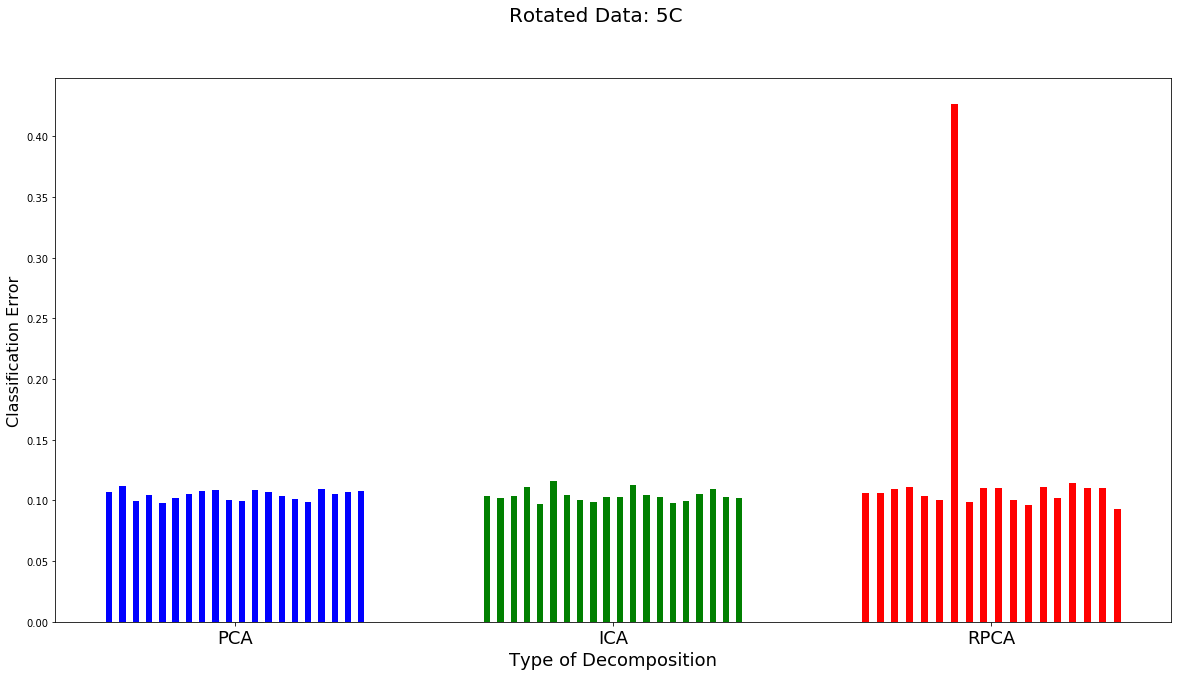

In [556]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.bar(np.linspace(1,2,len(rotate_score_pca[0])),rotate_score_pca[0], color = 'b', width = 0.5/len(rotate_score_pca[0]))
ax.bar(np.linspace(2.5,3.5,len(rotate_score_ica[0])),rotate_score_ica[0], color = 'g', width = 0.5/len(rotate_score_ica[0]))
ax.bar(np.linspace(4,5,len(rotate_score_rpca[0])),rotate_score_rpca[0], color = 'r', width = 0.5/len(rotate_score_rpca[0]))

ax.set_xticks([1.5,3.0,4.5])
ax.set_xticklabels(('PCA','ICA','RPCA'),fontsize=18);

fig.suptitle('Rotated Data: 5C', fontsize=20)
plt.xlabel('Type of Decomposition', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/rotated_5C_result.png')

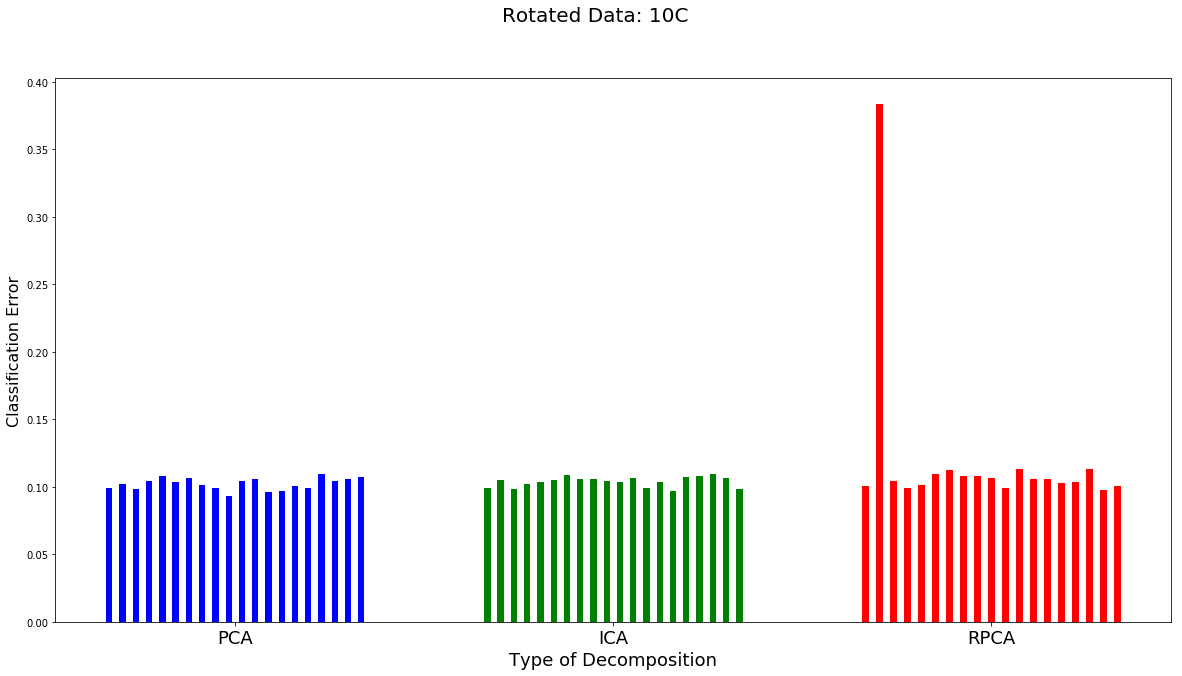

In [558]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.bar(np.linspace(1,2,len(rotate_score_pca[1])),rotate_score_pca[1], color = 'b', width = 0.5/len(rotate_score_pca[1]))
ax.bar(np.linspace(2.5,3.5,len(rotate_score_ica[1])),rotate_score_ica[1], color = 'g', width = 0.5/len(rotate_score_ica[1]))
ax.bar(np.linspace(4,5,len(rotate_score_rpca[1])),rotate_score_rpca[1], color = 'r', width = 0.5/len(rotate_score_rpca[1]))

ax.set_xticks([1.5,3.0,4.5])
ax.set_xticklabels(('PCA','ICA','RPCA'),fontsize=18);

fig.suptitle('Rotated Data: 10C', fontsize=20)
plt.xlabel('Type of Decomposition', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/rotated_10C_result.png')

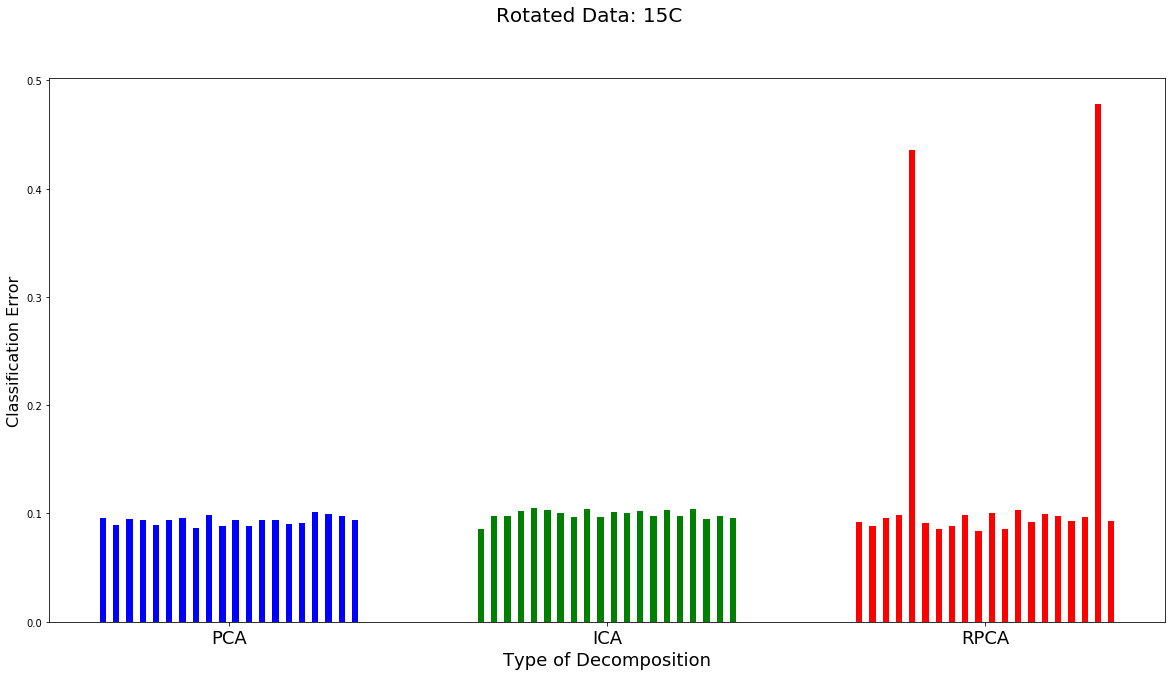

In [559]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.bar(np.linspace(1,2,len(rotate_score_pca[2])),rotate_score_pca[2], color = 'b', width = 0.5/len(rotate_score_pca[2]))
ax.bar(np.linspace(2.5,3.5,len(rotate_score_ica[2])),rotate_score_ica[2], color = 'g', width = 0.5/len(rotate_score_ica[2]))
ax.bar(np.linspace(4,5,len(rotate_score_rpca[2])),rotate_score_rpca[2], color = 'r', width = 0.5/len(rotate_score_rpca[2]))

ax.set_xticks([1.5,3.0,4.5])
ax.set_xticklabels(('PCA','ICA','RPCA'),fontsize=18);

fig.suptitle('Rotated Data: 15C', fontsize=20)
plt.xlabel('Type of Decomposition', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/rotated_15C_result.png')

0.426644182125
0.383522042881
0.43555769694
0.477957118767


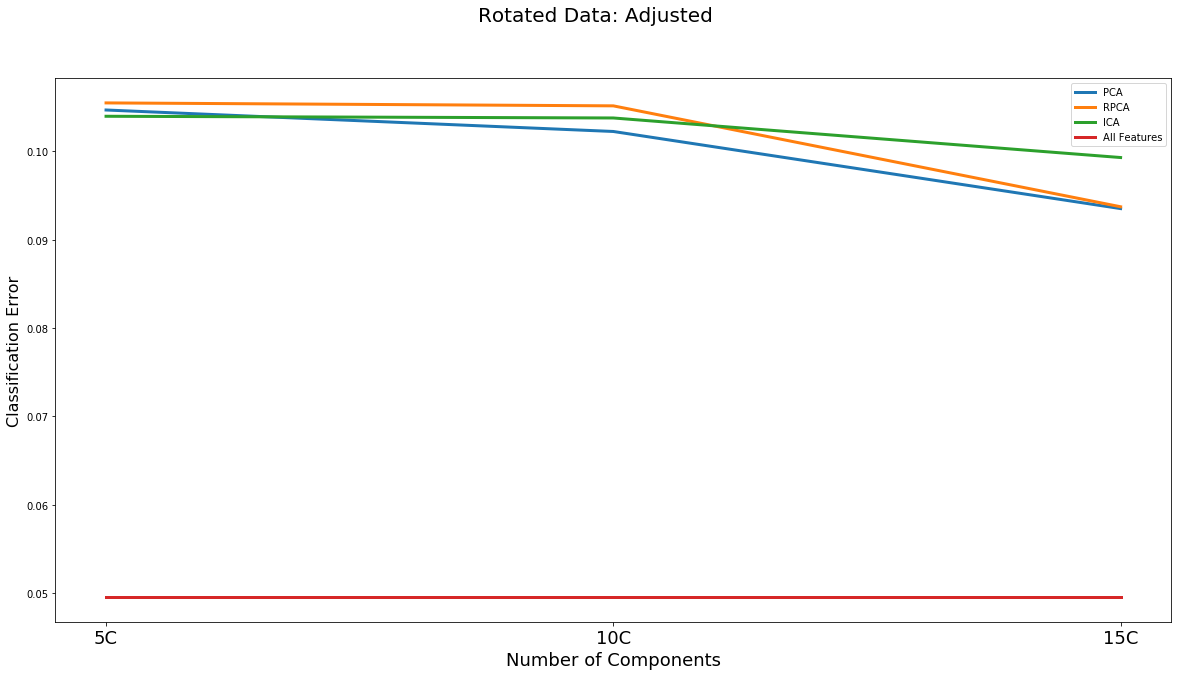

In [563]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.set_xticks([1,2,3])
ax.set_xticklabels(('5C','10C','15C'),fontsize=18)



ax.errorbar([1,2,3],[i.mean() for i in cal_error(rotate_score_pca)],label="PCA",lw=3)
ax.errorbar([1,2,3],[i.mean() for i in cal_error(rotate_score_rpca,0.35)],label="RPCA",lw=3)
ax.errorbar([1,2,3],[i.mean() for i in cal_error(rotate_score_ica)],label="ICA",lw=3)
ax.errorbar([1,2,3],[1-np.array(rotate_original_rs).mean()]*3,label="All Features",lw=3)



ax.legend()
# plt.figure()

fig.suptitle('Rotated Data: Adjusted', fontsize=20)
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/rotate_adjusted_result.png')


0.426644182125
0.383522042881
0.43555769694
0.477957118767
0.426644182125
0.383522042881
0.43555769694
0.477957118767


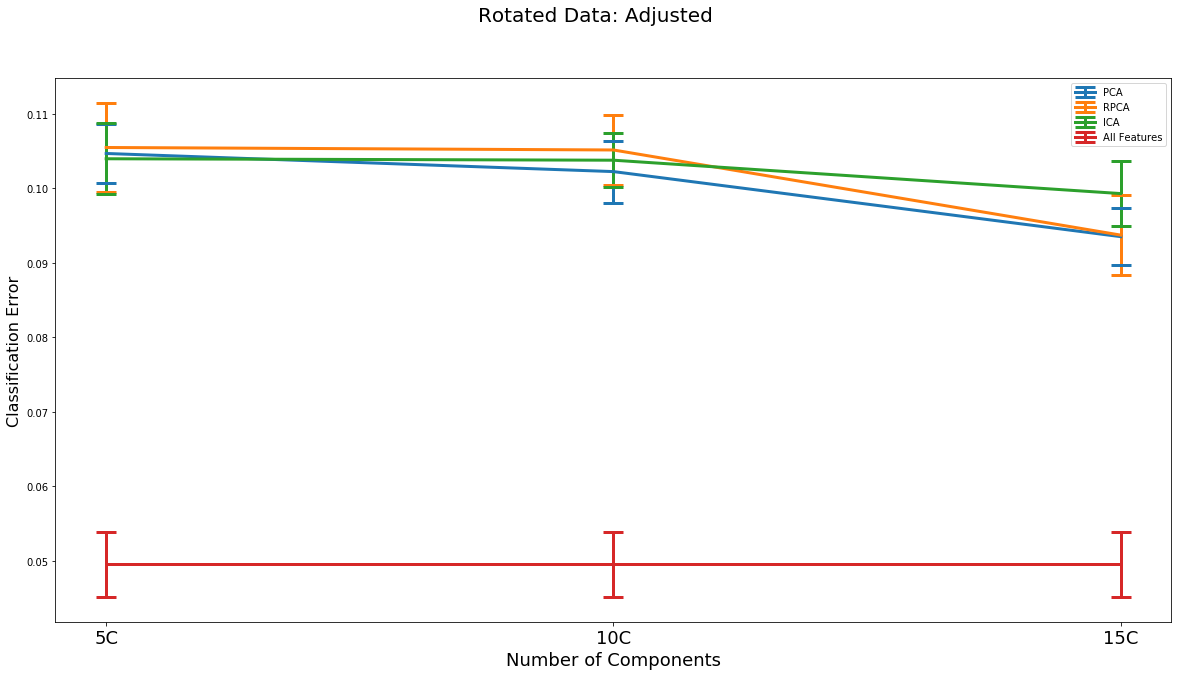

In [579]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.set_xticks([1,2,3])
ax.set_xticklabels(('5C','10C','15C'),fontsize=18)



ax.errorbar([1,2,3],[i.mean() for i in cal_error(rotate_score_pca)],label="PCA",yerr=[i.std() for i in cal_error(rotate_score_pca)],lw=3,capthick=3)
ax.errorbar([1,2,3],[i.mean() for i in cal_error(rotate_score_rpca,0.35)],yerr=[i.std() for i in cal_error(rotate_score_rpca,0.35)],label="RPCA",lw=3,capthick=3)
ax.errorbar([1,2,3],[i.mean() for i in cal_error(rotate_score_ica)],label="ICA",yerr=[i.std() for i in cal_error(rotate_score_ica)],lw=3,capthick=3)
ax.errorbar([1,2,3],[1-np.array(rotate_original_rs).mean()]*3,label="All Features",lw=3,yerr=[(1-np.array(rotate_original_rs)).std()]*3,capthick=3)



ax.legend()
# plt.figure()

fig.suptitle('Rotated Data: Adjusted', fontsize=20)
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/rotate_adjusted_result_errbar.png')


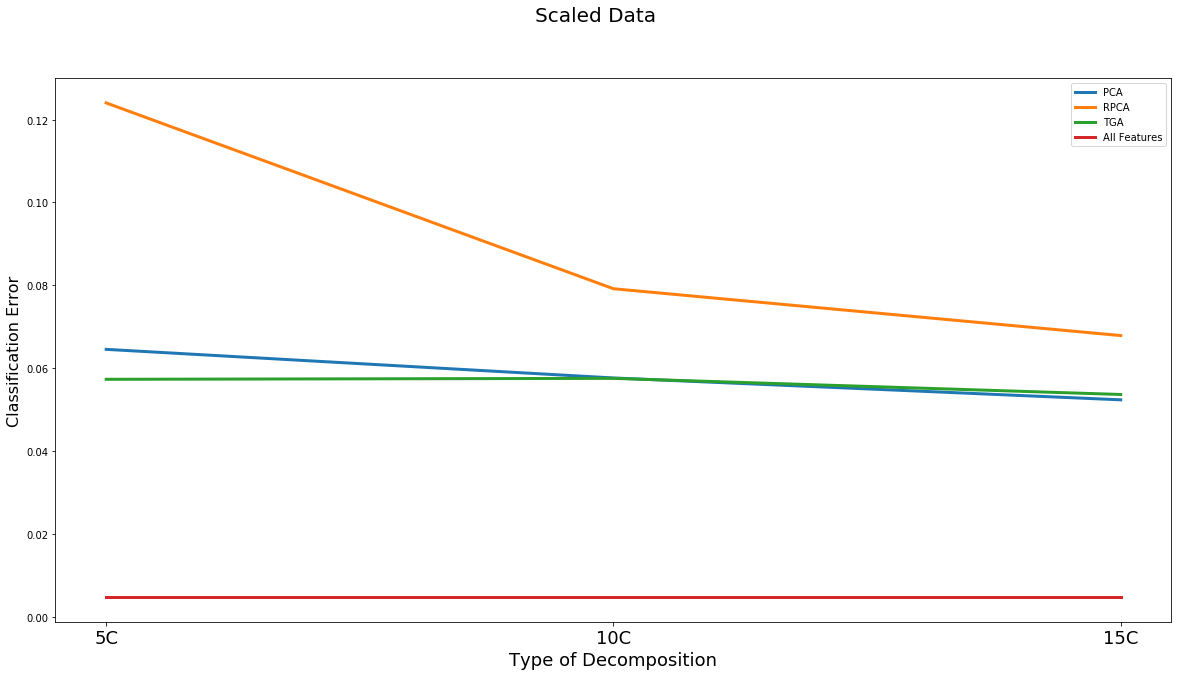

In [566]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.set_xticks([1,2,3])
ax.set_xticklabels(('5C','10C','15C'),fontsize=18)

ax.errorbar([1,2,3],[i.mean() for i in scaled_score_pca],label="PCA",lw=3)
ax.errorbar([1,2,3],[i.mean() for i in scaled_score_rpca],label="RPCA",lw=3)
ax.errorbar([1,2,3],[i.mean() for i in scaled_score_ica],label="TGA",lw=3)
ax.errorbar([1,2,3],[1-np.array(scaled_original_rs).mean()]*3,label="All Features",lw=3)


ax.legend()
# plt.figure()

fig.suptitle('Scaled Data', fontsize=20)
plt.xlabel('Type of Decomposition', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/scaled_result.png')

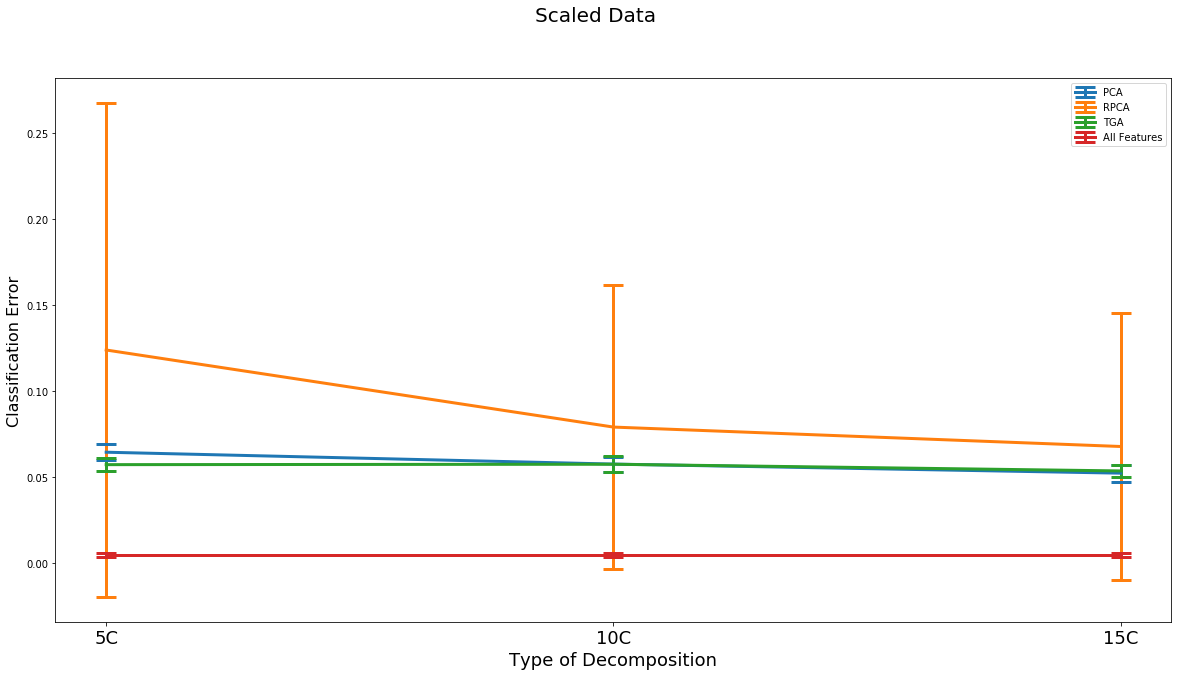

In [565]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.set_xticks([1,2,3])
ax.set_xticklabels(('5C','10C','15C'),fontsize=18)

ax.errorbar([1,2,3],[i.mean() for i in scaled_score_pca],label="PCA",lw=3,yerr=[i.std() for i in scaled_score_pca],capthick=3)
ax.errorbar([1,2,3],[i.mean() for i in scaled_score_rpca],label="RPCA",lw=3,yerr=[i.std() for i in scaled_score_rpca],capthick=3)
ax.errorbar([1,2,3],[i.mean() for i in scaled_score_ica],label="TGA",lw=3,yerr=[i.std() for i in scaled_score_ica],capthick=3)
ax.errorbar([1,2,3],[1-np.array(scaled_original_rs).mean()]*3,label="All Features",lw=3,yerr=[(1-np.array(scaled_original_rs)).std()]*3,capthick=3)


ax.legend()
# plt.figure()

fig.suptitle('Scaled Data', fontsize=20)
plt.xlabel('Type of Decomposition', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/scaled_result_errbar.png')

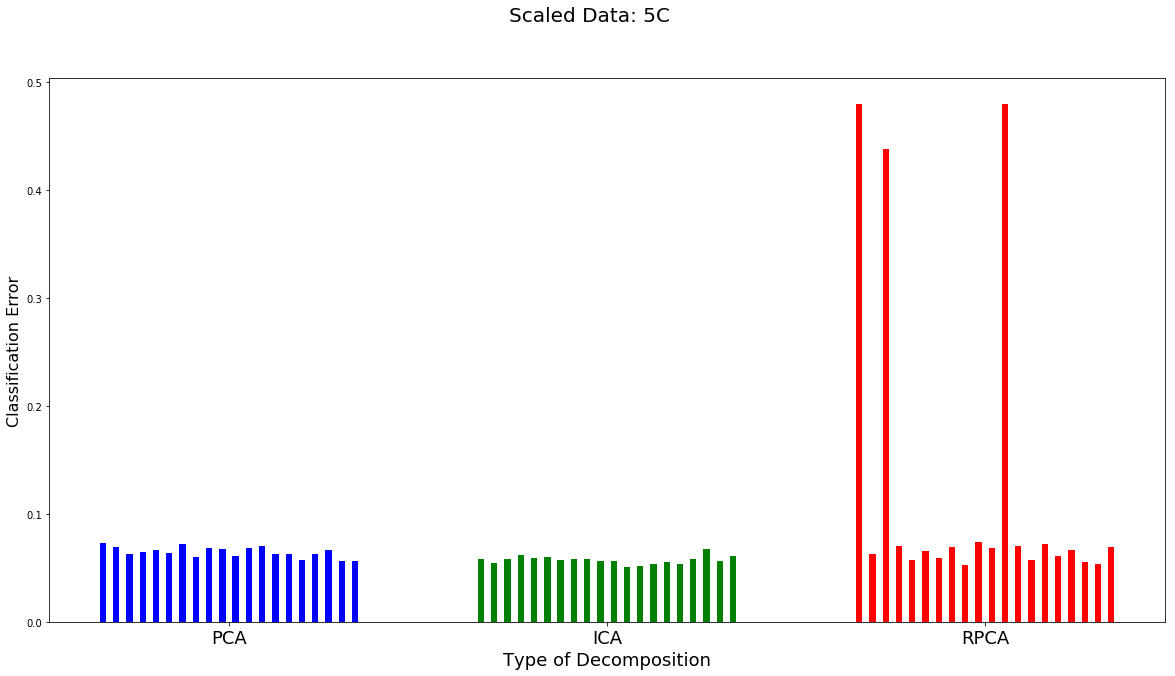

In [567]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.bar(np.linspace(1,2,len(scaled_score_pca[0])),scaled_score_pca[0], color = 'b', width = 0.5/len(scaled_score_pca[0]))
ax.bar(np.linspace(2.5,3.5,len(scaled_score_ica[0])),scaled_score_ica[0], color = 'g', width = 0.5/len(scaled_score_ica[0]))
ax.bar(np.linspace(4,5,len(scaled_score_rpca[0])),scaled_score_rpca[0], color = 'r', width = 0.5/len(scaled_score_rpca[0]))

ax.set_xticks([1.5,3.0,4.5])
ax.set_xticklabels(('PCA','ICA','RPCA'),fontsize=18);

fig.suptitle('Scaled Data: 5C', fontsize=20)
plt.xlabel('Type of Decomposition', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/scaled_5C_result.png')

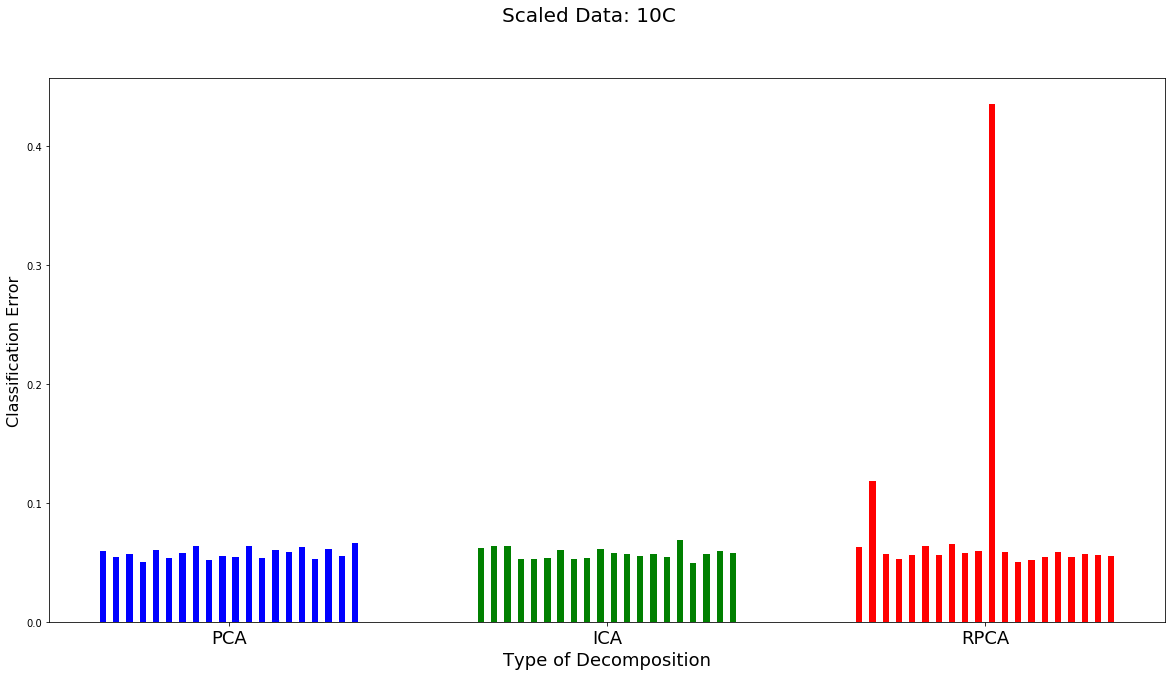

In [568]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.bar(np.linspace(1,2,len(scaled_score_pca[1])),scaled_score_pca[1], color = 'b', width = 0.5/len(scaled_score_pca[1]))
ax.bar(np.linspace(2.5,3.5,len(scaled_score_ica[1])),scaled_score_ica[1], color = 'g', width = 0.5/len(scaled_score_ica[1]))
ax.bar(np.linspace(4,5,len(scaled_score_rpca[1])),scaled_score_rpca[1], color = 'r', width = 0.5/len(scaled_score_rpca[1]))

ax.set_xticks([1.5,3.0,4.5])
ax.set_xticklabels(('PCA','ICA','RPCA'),fontsize=18);


fig.suptitle('Scaled Data: 10C', fontsize=20)
plt.xlabel('Type of Decomposition', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/scaled_10C_result.png')


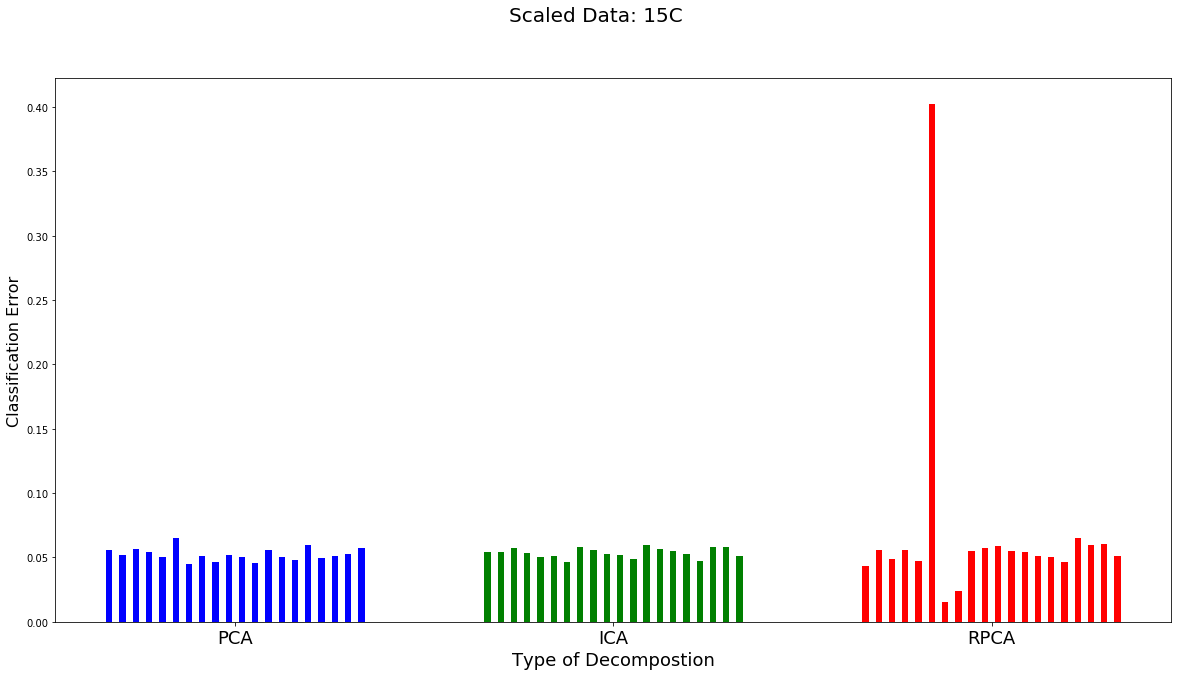

In [569]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.bar(np.linspace(1,2,len(scaled_score_pca[2])), scaled_score_pca[2], color = 'b', width = 0.5/len(scaled_score_pca[2]))
ax.bar(np.linspace(2.5,3.5,len(scaled_score_ica[2])), scaled_score_ica[2], color = 'g', width = 0.5/len(scaled_score_ica[2]))
ax.bar(np.linspace(4,5,len(scaled_score_rpca[2])), scaled_score_rpca[2], color = 'r', width = 0.5/len(scaled_score_rpca[2]))

ax.set_xticks([1.5,3.0,4.5])
ax.set_xticklabels(('PCA','ICA','RPCA'),fontsize=18);

fig.suptitle('Scaled Data: 15C', fontsize=20)
plt.xlabel('Type of Decompostion', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/scaled_15C_result.png')

0.47892074199
0.437966754999
0.479161647796
0.435075885329
0.40207178993


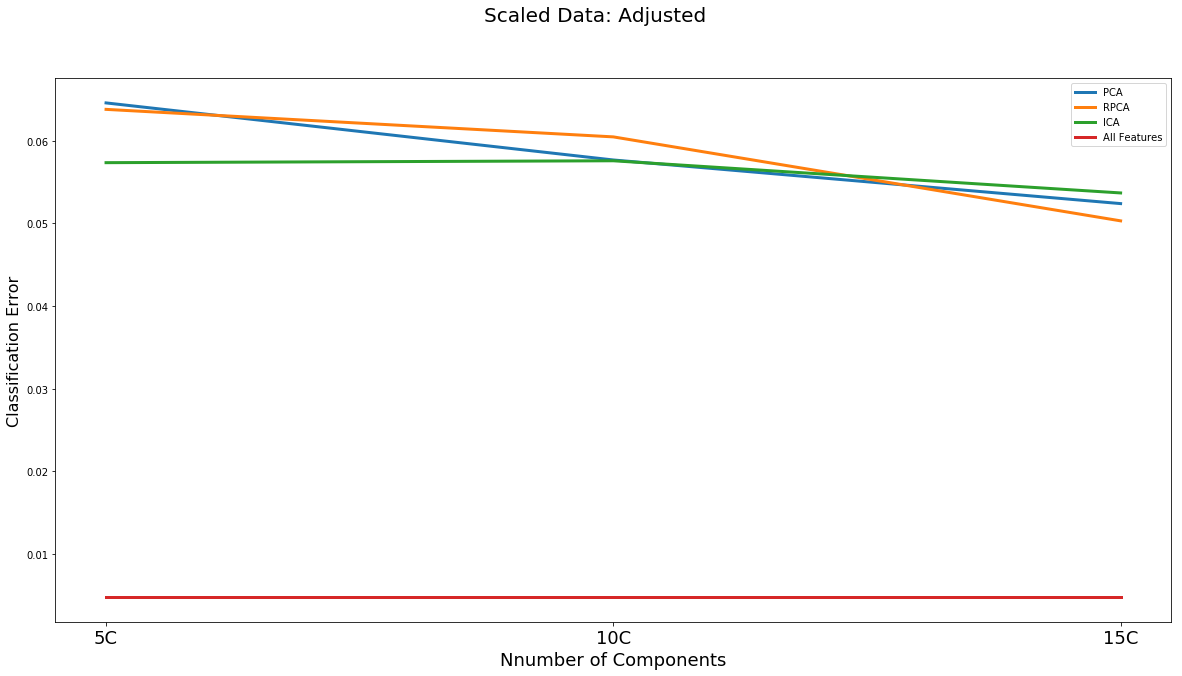

In [571]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.set_xticks([1,2,3])
ax.set_xticklabels(('5C','10C','15C'),fontsize=18)




ax.errorbar([1,2,3],[i.mean() for i in cal_error(scaled_score_pca)],label="PCA",lw=3)
ax.errorbar([1,2,3],[i.mean() for i in cal_error(scaled_score_rpca,0.4)],label="RPCA",lw=3)
ax.errorbar([1,2,3],[i.mean() for i in cal_error(scaled_score_ica)],label="ICA",lw=3)
ax.errorbar([1,2,3],[1-np.array(scaled_original_rs).mean()]*3,label="All Features",lw=3)


ax.legend()

fig.suptitle('Scaled Data: Adjusted', fontsize=20)
plt.xlabel('Nnumber of Components', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/scaled_adjusted_result.png')


0.47892074199
0.437966754999
0.479161647796
0.435075885329
0.40207178993
0.47892074199
0.437966754999
0.479161647796
0.435075885329
0.40207178993


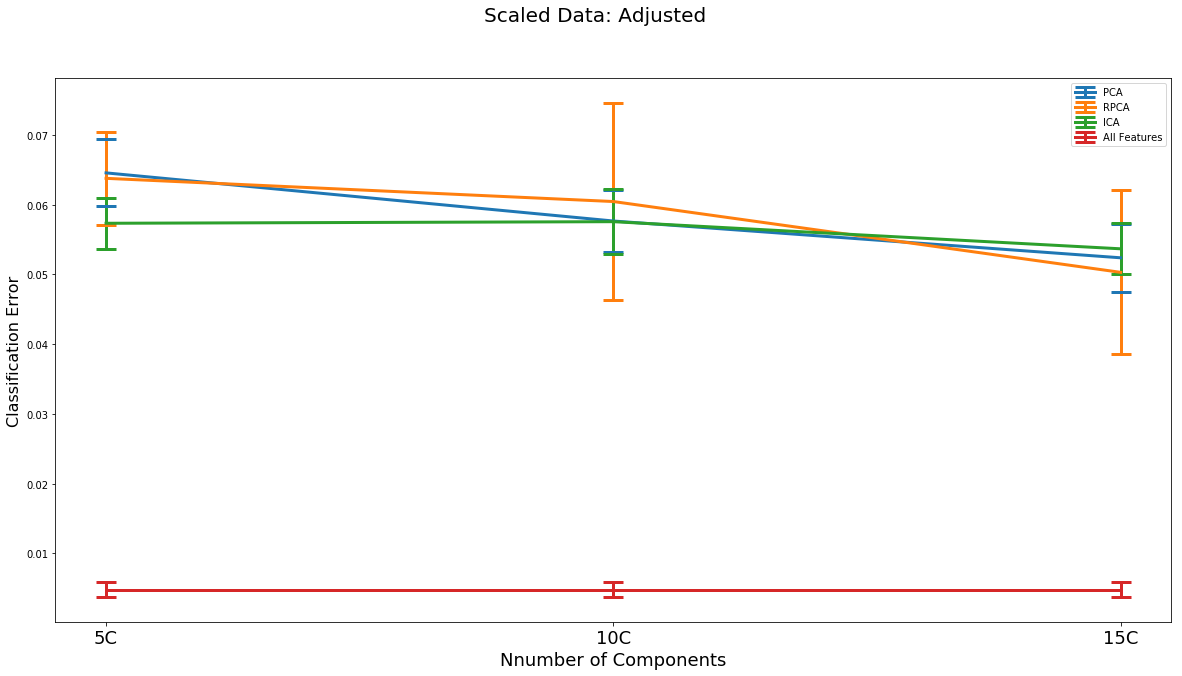

In [570]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.set_xticks([1,2,3])
ax.set_xticklabels(('5C','10C','15C'),fontsize=18)




ax.errorbar([1,2,3],[i.mean() for i in cal_error(scaled_score_pca)],label="PCA",yerr=[i.std() for i in cal_error(scaled_score_pca)],lw=3,capthick=3)
ax.errorbar([1,2,3],[i.mean() for i in cal_error(scaled_score_rpca,0.4)],yerr=[i.std() for i in cal_error(scaled_score_rpca,0.2)],label="RPCA",lw=3,capthick=3)
ax.errorbar([1,2,3],[i.mean() for i in cal_error(scaled_score_ica)],label="ICA",yerr=[i.std() for i in cal_error(scaled_score_ica)],lw=3,capthick=3)
ax.errorbar([1,2,3],[1-np.array(scaled_original_rs).mean()]*3,label="All Features",lw=3,yerr=[(1-np.array(scaled_original_rs)).std()]*3,capthick=3)


ax.legend()

fig.suptitle('Scaled Data: Adjusted', fontsize=20)
plt.xlabel('Nnumber of Components', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/scaled_adjusted_result_errbar.png')


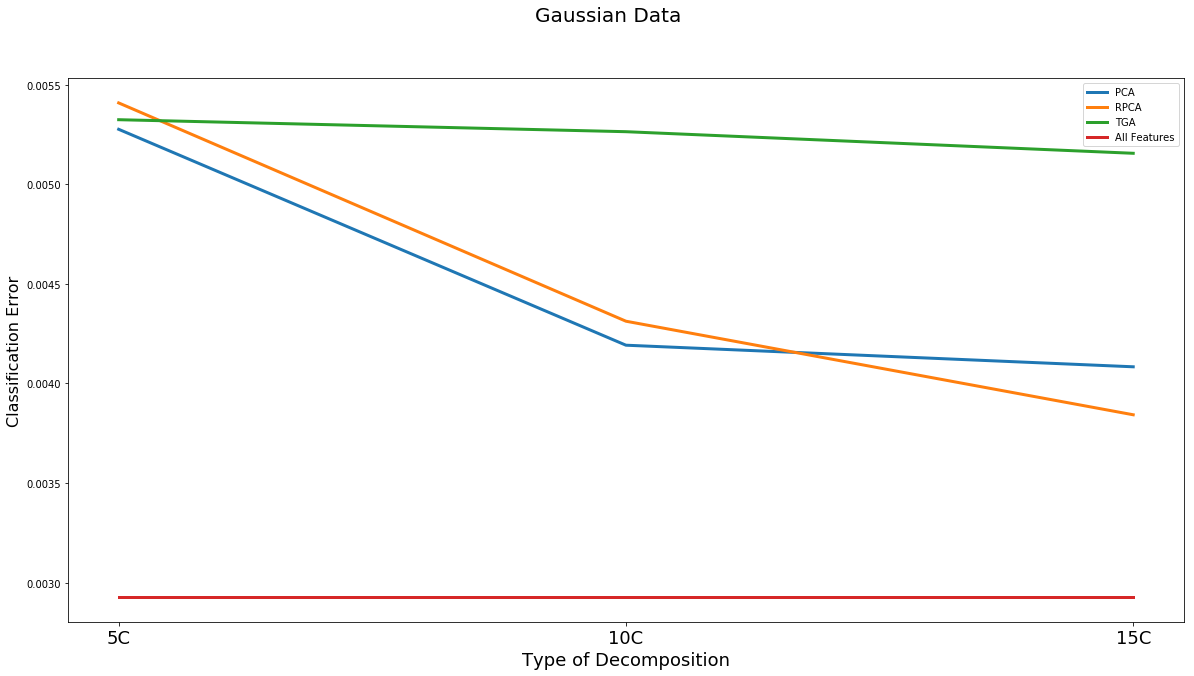

In [581]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.set_xticks([1,2,3])
ax.set_xticklabels(('5C','10C','15C'),fontsize=18)

ax.errorbar([1,2,3],[i.mean() for i in gaussed_score_pca],label="PCA",lw=3)
ax.errorbar([1,2,3],[i.mean() for i in gaussed_score_rpca],label="RPCA",lw=3)
ax.errorbar([1,2,3],[i.mean() for i in gaussed_score_ica],label="TGA",lw=3)
ax.errorbar([1,2,3],[1-np.array(gaussed_original_rs).mean()]*3,label="All Features",lw=3)


ax.legend()
# plt.figure()

fig.suptitle('Gaussian Data', fontsize=20)
plt.xlabel('Type of Decomposition', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/gaussian_result.png')

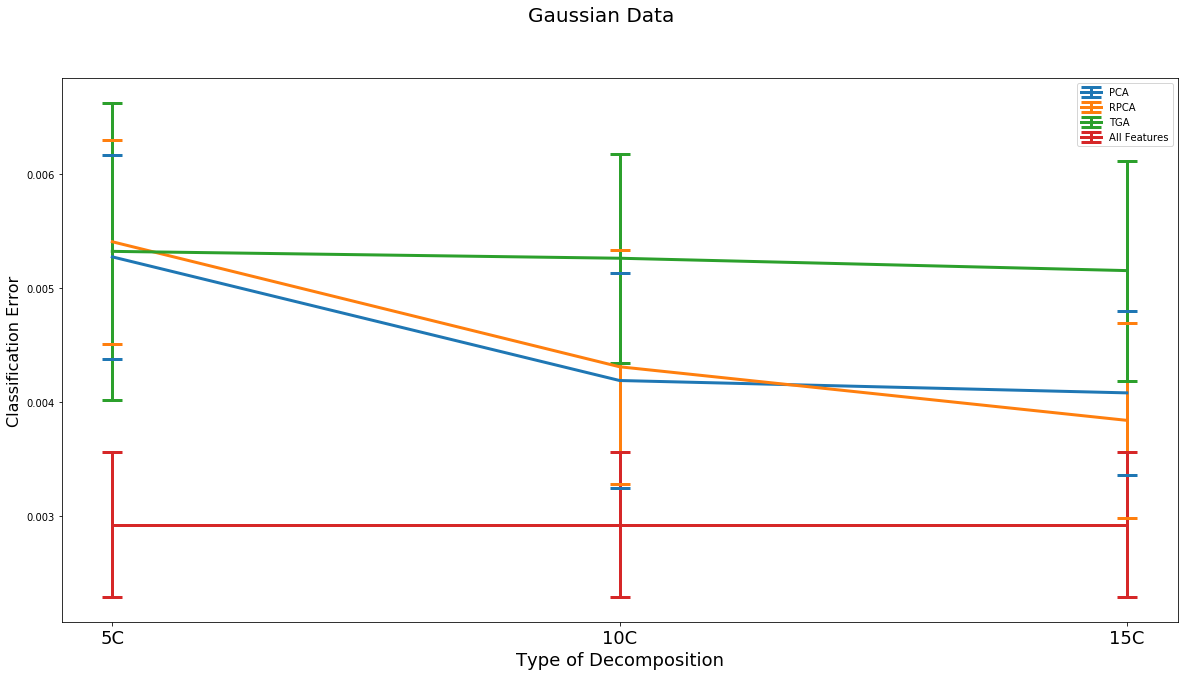

In [582]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.set_xticks([1,2,3])
ax.set_xticklabels(('5C','10C','15C'),fontsize=18)

ax.errorbar([1,2,3],[i.mean() for i in gaussed_score_pca],label="PCA",lw=3,yerr=[i.std() for i in gaussed_score_pca],capthick=3)
ax.errorbar([1,2,3],[i.mean() for i in gaussed_score_rpca],label="RPCA",lw=3,yerr=[i.std() for i in gaussed_score_rpca],capthick=3)
ax.errorbar([1,2,3],[i.mean() for i in gaussed_score_ica],label="TGA",lw=3,yerr=[i.std() for i in gaussed_score_ica],capthick=3)
ax.errorbar([1,2,3],[1-np.array(gaussed_original_rs).mean()]*3,label="All Features",lw=3,yerr=[(1-np.array(gaussed_original_rs)).std()]*3,capthick=3)


ax.legend()
# plt.figure()

fig.suptitle('Gaussian Data', fontsize=20)
plt.xlabel('Type of Decomposition', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/gaussian_result_errbar.png')

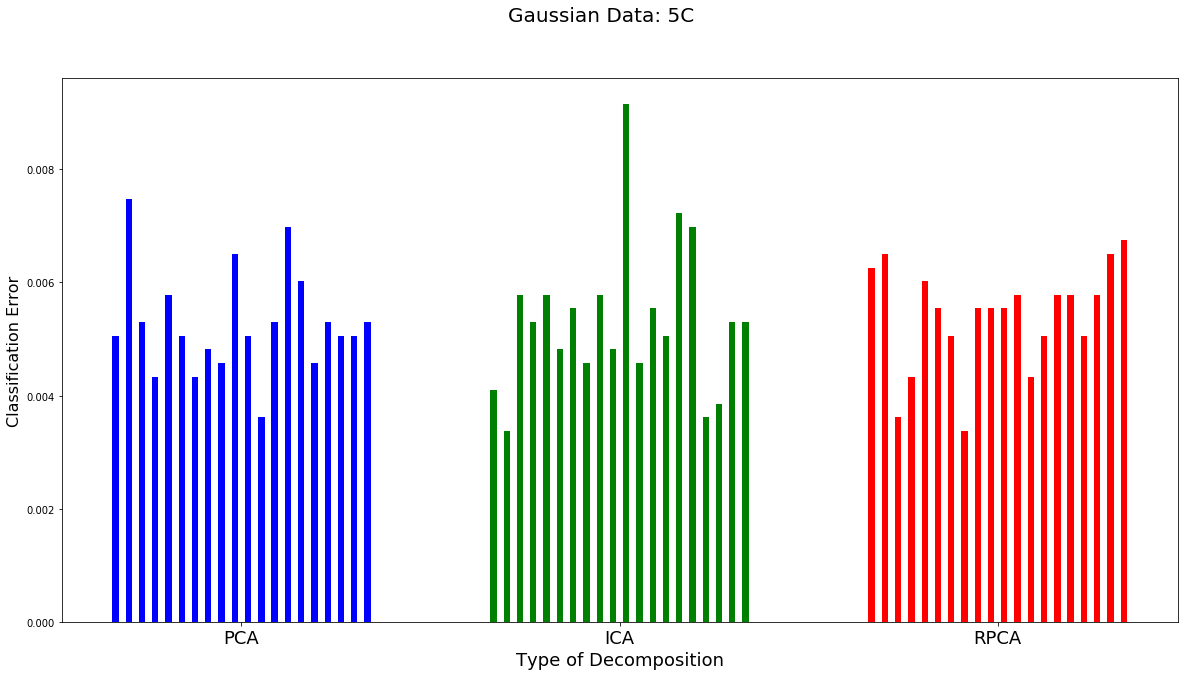

In [583]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.bar(np.linspace(1,2,len(gaussed_score_pca[0])),gaussed_score_pca[0], color = 'b', width = 0.5/len(gaussed_score_pca[0]))
ax.bar(np.linspace(2.5,3.5,len(gaussed_score_ica[0])),gaussed_score_ica[0], color = 'g', width = 0.5/len(gaussed_score_ica[0]))
ax.bar(np.linspace(4,5,len(gaussed_score_rpca[0])),gaussed_score_rpca[0], color = 'r', width = 0.5/len(gaussed_score_rpca[0]))

ax.set_xticks([1.5,3.0,4.5])
ax.set_xticklabels(('PCA','ICA','RPCA'),fontsize=18);

fig.suptitle('Gaussian Data: 5C', fontsize=20)
plt.xlabel('Type of Decomposition', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/gaussed_5C_result.png')

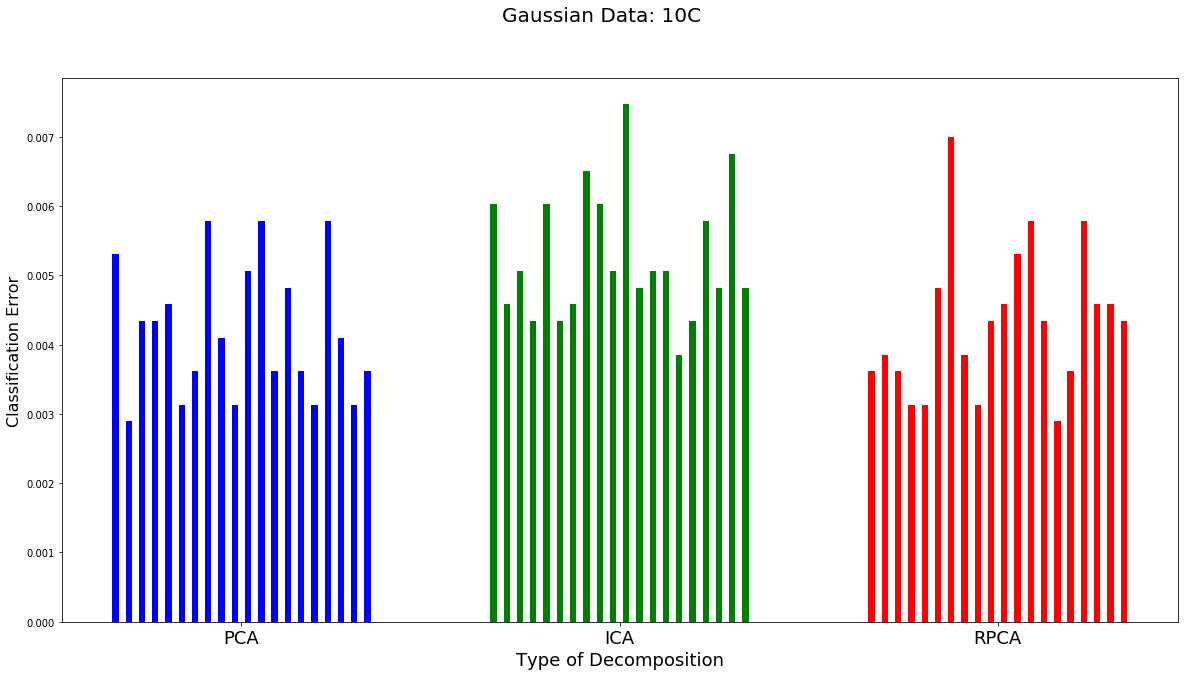

In [584]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.bar(np.linspace(1,2,len(gaussed_score_pca[1])),gaussed_score_pca[1], color = 'b', width = 0.5/len(gaussed_score_pca[1]))
ax.bar(np.linspace(2.5,3.5,len(gaussed_score_ica[1])),gaussed_score_ica[1], color = 'g', width = 0.5/len(gaussed_score_ica[1]))
ax.bar(np.linspace(4,5,len(gaussed_score_rpca[1])),gaussed_score_rpca[1], color = 'r', width = 0.5/len(gaussed_score_rpca[1]))

ax.set_xticks([1.5,3.0,4.5])
ax.set_xticklabels(('PCA','ICA','RPCA'),fontsize=18);

fig.suptitle('Gaussian Data: 10C', fontsize=20)
plt.xlabel('Type of Decomposition', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/gaussed_10C_result.png')

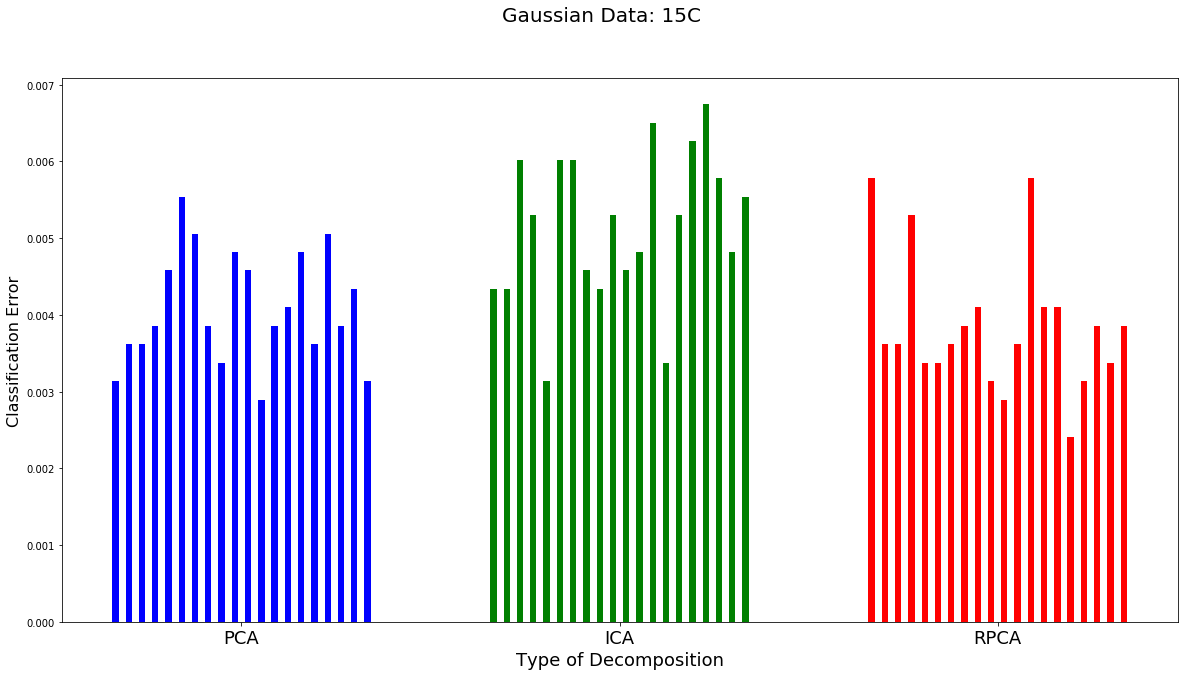

In [585]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)

ax.bar(np.linspace(1,2,len(gaussed_score_pca[2])),gaussed_score_pca[2], color = 'b', width = 0.5/len(gaussed_score_pca[2]))
ax.bar(np.linspace(2.5,3.5,len(gaussed_score_ica[2])),gaussed_score_ica[2], color = 'g', width = 0.5/len(gaussed_score_ica[2]))
ax.bar(np.linspace(4,5,len(gaussed_score_rpca[2])),gaussed_score_rpca[2], color = 'r', width = 0.5/len(gaussed_score_rpca[2]))

ax.set_xticks([1.5,3.0,4.5])
ax.set_xticklabels(('PCA','ICA','RPCA'),fontsize=18);

fig.suptitle('Gaussian Data: 15C', fontsize=20)
plt.xlabel('Type of Decomposition', fontsize=18)
plt.ylabel('Classification Error', fontsize=16)
fig.savefig('figures/gaussed_15C_result.png')

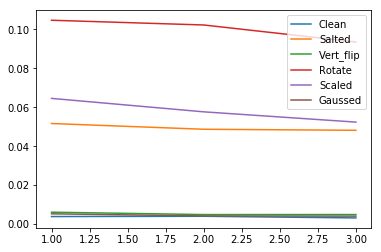

In [586]:
plt.plot([1,2,3],[(i).mean() for i in clean_score_pca],label="Clean")

plt.plot([1,2,3],[(i).mean() for i in salted_score_pca],label="Salted")

plt.plot([1,2,3],[(i).mean() for i in vert_score_pca],label="Vert_flip")

plt.plot([1,2,3],[(i).mean() for i in rotate_score_pca],label="Rotate")

plt.plot([1,2,3],[(i).mean() for i in scaled_score_pca],label="Scaled")

plt.plot([1,2,3],[(i).mean() for i in gaussed_score_pca],label="Gaussed")


# plt.plot([1,2,3],[1-np.array(original_rs).mean()]*3,label="All Features")

plt.legend()
plt.figure()

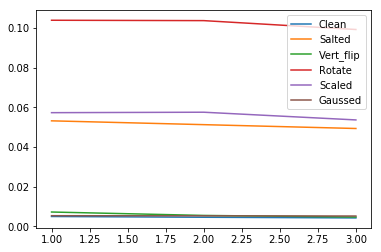

In [588]:


plt.plot([1,2,3],[(i).mean() for i in clean_score_ica],label="Clean")

plt.plot([1,2,3],[(i).mean() for i in salted_score_ica],label="Salted")

plt.plot([1,2,3],[(i).mean() for i in vert_score_ica],label="Vert_flip")

plt.plot([1,2,3],[(i).mean() for i in rotate_score_ica],label="Rotate")

plt.plot([1,2,3],[(i).mean() for i in scaled_score_ica],label="Scaled")

plt.plot([1,2,3],[(i).mean() for i in gaussed_score_ica],label="Gaussed")

# plt.plot([1,2,3],[1-np.array(original_rs).mean()]*3,label="All Features")

plt.legend()
plt.figure()

0.43676222597
0.355095157793
0.401589978318
0.426644182125
0.383522042881
0.43555769694
0.477957118767
0.47892074199
0.437966754999
0.479161647796
0.435075885329
0.40207178993


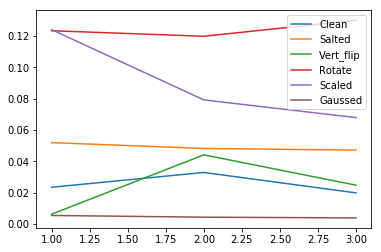

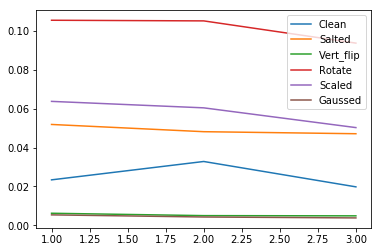

In [587]:

plt.plot([1,2,3],[(i).mean() for i in clean_score_rpca],label="Clean")

plt.plot([1,2,3],[(i).mean() for i in salted_score_rpca],label="Salted")

plt.plot([1,2,3],[(i).mean() for i in vert_score_rpca],label="Vert_flip")

plt.plot([1,2,3],[(i).mean() for i in rotate_score_rpca],label="Rotate")

plt.plot([1,2,3],[(i).mean() for i in scaled_score_rpca],label="Scaled")

plt.plot([1,2,3],[(i).mean() for i in gaussed_score_rpca],label="Gaussed")

# plt.plot([1,2,3],[1-np.array(original_rs).mean()]*3,label="All Features")

plt.legend()
plt.figure()

plt.plot([1,2,3],[(i).mean() for i in clean_score_rpca],label="Clean")

plt.plot([1,2,3],[(i).mean() for i in salted_score_rpca],label="Salted")

plt.plot([1,2,3],[ i.mean() for i in cal_error(vert_score_rpca,0.2)],label="Vert_flip")

plt.plot([1,2,3],[ i.mean() for i in cal_error(rotate_score_rpca,0.35)],label="Rotate")

plt.plot([1,2,3],[ i.mean() for i in cal_error(scaled_score_rpca,0.4)],label="Scaled")

plt.plot([1,2,3],[(i).mean() for i in gaussed_score_rpca],label="Gaussed")

# plt.plot([1,2,3],[1-np.array(original_rs).mean()]*3,label="All Features")

plt.legend()
plt.figure()


In [589]:
def all_prob_pca_score(xs,ys,c,f):
    
    rs = []
    
    for p in range(11):
        print("\nNoise probability:",p/10)

        rs += [iterative_run_pca(xs,ys,c,20,f,p)]
    return rs

def all_prob_ica_score(xs,ys,c,f):
    
    rs = []
    
    for p in range(11):
        print("\nNoise probability:",p/10)

        rs += [iterative_run_ica(xs,ys,c,20,f,p)]
    return rs

def all_prob_rpca_score(xs,ys,c,f):
    
    rs = []
    
    for p in range(11):
        print("\nNoise probability:",p/10)
    
        rs += [iterative_run_rpca(xs,ys,c,20,f,p)]
    return rs


In [ ]:
all_vert_flip_score_pca = all_prob_pca_score(new_xs,new_ys,10,vertical_flip)
all_vert_flip_score_ica = all_prob_ica_score(new_xs,new_ys,10,vertical_flip)
# all_vert_flip_score_rpca = all_prob_rpca_score(new_xs,new_ys,10,vertical_flip)


Noise probability: 0.0
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
Noise probability: 0.1
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
Noise probability: 0.2
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
Noise probability: 0.3
0,1,

In [ ]:
# all_vert_flip_score_pca

In [ ]:
plt.plot(range(11),[np.array(i)[0].mean() for i in all_vert_flip_score_pca])
plt.plot(range(11),[np.array(i)[0].mean() for i in all_vert_flip_score_ica])

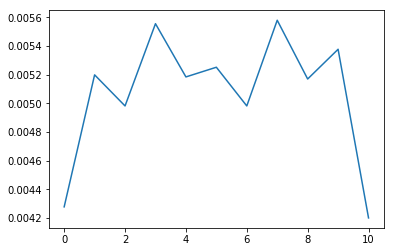

In [ ]:
all_salted_score_pca = all_prob_pca_score(new_xs,new_ys,10,sp_noise)
all_salted_score_ica = all_prob_ica_score(new_xs,new_ys,10,sp_noise)
# all_salted_score_rpca = all_prob_rpca_score(new_xs,new_ys,10,sp_noise)

In [ ]:
plt.plot(range(11),[1-np.array(i)[0].mean() for i in all_salted_score_pca])
plt.plot(range(11),[1-np.array(i)[0].mean() for i in all_salted_score_ica])

In [ ]:
all_rotated_score_pca = all_prob_pca_score(new_xs,new_ys,10,rotate180)
all_rotated_score_ica = all_prob_ica_score(new_xs,new_ys,10,rotate180)
# all_rotated_score_rpca = all_prob_rpca_score(new_xs,new_ys,10,rotate180)

In [ ]:
plt.plot(range(11),[1-np.array(i)[0].mean() for i in all_rotated_score_pca])
plt.plot(range(11),[1-np.array(i)[0].mean() for i in all_rotated_score_ica])

In [ ]:
# plt.plot(range(11),[1-np.array(i).mean() for i in all_rotated_score])

In [ ]:
all_gaussian_score_pca = all_prob_pca_score(new_xs,new_ys,10,gaussian)
all_gaussian_score_ica = all_prob_ica_score(new_xs,new_ys,10,gaussian)
# all_gaussian_score_rpca = all_prob_rpca_score(new_xs,new_ys,10,gaussian)

In [ ]:
plt.plot(range(11),[1-np.array(i)[0].mean() for i in all_gaussian_score_pca])
plt.plot(range(11),[1-np.array(i)[0].mean() for i in all_gaussian_score_ica])

In [ ]:
all_scaled_score_pca = all_prob_pca_score(new_xs,new_ys,10,scale_down)
all_scaled_score_ica = all_prob_ica_score(new_xs,new_ys,10,scale_down)
# all_scaled_score_rpca = all_prob_rpca_score(new_xs,new_ys,10,scale_down)

In [ ]:
plt.plot(range(11),[1-np.array(i)[0].mean() for i in all_scaled_score_pca])
plt.plot(range(11),[1-np.array(i)[0].mean() for i in all_scaled_score_ica])